**CSDS: Christian Camilo Urcuqui López**

**Fecha: 13 Febrero 2023**

El presente notebook abarca las respuestas al reto MP Sec Tech de Mercadolibre. A continuación, se presenta el contenido del libro:
+ [Descripción](#Descripción)
+ [Objetivo](#Objetivo)
+ [Entregables esperados](#Entregables-esperados)
+ [Bonus](#Bonus)
+ [EDA](#EDA)    
    + [Datos](#Datos)
    + [Paquetes](#Paquetes)
    + [Análisis de irregularidades en datos](#Análisis-de-irregularidades-en-datos)
    + [Procesamiento y limpieza](#Procesamiento-y-limpieza)
    + [Exploración](#Exploración)
+ [Modelamiento](#Modelamiento)
    + [Primer modelo](#Pimer-modelo)
    + [Segundo modelo](#Segundo-modelo)
    + [Tercer modelo](#Tercer-modelo)
    + [Cuarto modelo](#Cuarto-modelo)
+ [Conclusiones e insights](#Conclusiones-e-insights)
+ [Trabajo futuro](#Trabajo-futuro)

# Descripción

El equipo de MP Sec Tech de Mercado Libre, se encarga de securizar las aplicaciones y tecnologías internas en Meli con impacto en la unidad de negocio de Mercado Pago, dichas aplicaciones y tecnologías son utilizadas por colaboradores internos para diferentes fines. **Uno de los mayores desafíos de este equipo es poder determinar si
un usuario realiza acciones anómalas o indebidas sobre dichas aplicaciones y tecnologías.**

Para empezar a implementar técnicas de **análisis de comportamiento de usuarios**, nos pidieron que evaluaramos el siguiente [dataset](https://data.mendeley.com/datasets/9k3pkspfxm/1) de prueba, el cual contiene acciones que diferentes usuarios realizaron en un site educativo.

Aunque el contexto de consumo sobre diferentes aplicaciones en un marco corporativo es diferente, **nos interesa identificar diferentes observaciones con respecto al comportamiento de los usuarios**, a fin de trasladar luego dichas
observaciones a técnicas o modelos que nos permitan identificar anomalías en nuestro dataset más complejo.

## Objetivo

Realizar un análisis sobre el dataset propuesto, contemplando los siguientes puntos:
1. Consumir la información de ambos “experimentos” publicados, estableciendo un proceso de unificación de datasets. ✔️
2. Establecer un proceso de limpieza y transformación de información de verlo necesario. ✔️
3. Desarrollar un análisis exploratorio de datos, “EDA” , sobre el dataset completo, 
teniendo en cuenta los objetivos mencionados en la descripción del desafío. ✔️
    + Aclaración: No se poseen limitaciones en el o los scopes seleccionados para
evaluar, el análisis puede enfocarse en diferentes features del dataset o en
alguna combinación/correlación de los mismos.
    + Ejemplo base: Un miembro del equipo nos dejó una idea básica para poder
inspirar este análisis: “Podríamos evaluar los horarios de accesos de cada
usuario para determinar irregularidades de uso del sitio para dicho usuario o
sacar algún estimado de “horario normal de utilización” para luego agregar
esta feature binaria a nuestro dataset.*


## Entregables esperados

+ Jupyter Notebook, script o código de implementación y proceso EDA (dependiendo
del método y lenguaje utilizado).** ✔️
+ Informe con insights que surgen del análisis de la información (no es necesario en
caso de incluirlo en un recurso como la Jupyter). ✔️
+ Informe de cualquier otros supuestos, comentarios, observaciones del análisis,
problemas y soluciones con los que se encontró al realizar este challenge. ⚠️**Se adjuntan en el presente notebook**
+ Archivo de texto con respuestas a las siguientes preguntas: ✔️ **ver archivo respuestas.pdf**
    + Indicar qué información necesitarías para mejorar/ampliar tu entregable.
    + ¿Cómo crees que podría mejorarse el dataset desde la creación del mismo si
lo tuvieses que procesar?
    + ¿Cuáles serían las ventajas de poseer labels en este dataset?
    + ¿De poseer aún más datos relacionados con el consumo de dicho site, crees
que podríamos identificar ataques sobre el mismo?¿De qué tipo?.


## Bonus

Estos puntos no son estrictamente necesarios pero tomaremos su implementación como un
“plus” en la entrega 💪 .
+ Implementar un modelo de detección de anomalías (ya existente o desarrollado
personalmente) sobre el dataset propuesto.


## EDA

En la presente unidad se procede a realizar el análisis exploaratorio de la información de los registros en bruto propuestos en:

```
Xie, Haihua; Chang, Carl K.; Yang, Jingwei (2017), “Records of Operations on the CoRE Systems”, Mendeley Data, V1, doi: 10.17632/9k3pkspfxm.1
```

### Datos

Los datos incluyen el comportamiento y las actividades realizadas por un conjunto de participantes de la IOWA State University sobre el sistema CoRE. Los datos se encuentran dividos en dos excel que corresponden al experimento uno y dos (resultado conseguido y explicado en el paper `A Statistical Analysis Approach to Predict User's Changing Requirements for Software Service Evolution, publicado en Journal of Systems and Software`).
Cada archivo contiene las pestañas "raw records" y "processed data", donde las filas corresponden a una captura sobre la acción del usuario sobre el sistema CoRE.

***

Las variables para el *raw records* son las siguientes:
1. Time: el punto en el tiempo el usuario ejecuta una operación
2. Login ID: el ID del usuario proporcionado por el CoRE system.
3. Action: Incluye el click del mouse en un botón o un link, una selección de un menú drop-down.
4. Page: la página actual donde la acción ocurre.
5. Next Page: la página siguiente que el sistema va a redireccionar.
7. Content: contenido de la página web (input de usuario y respuesta del sistema para la acción del usuario)
8. Goal: objetivo autoreportado por el usuario
***

Las variables del *processed data* son obtenidas del raw data y son las siguientes:
1. Observation: incluye la acción del usuario y el contenido en los datos en bruto.
2. Time Interval: el intervalo de tiempo entre los puntos de tiempo de las acciones consecutivas del usuario.
3. Goal: objetivo autoreportado por el usuario

*El diccionario de datos no menciona que hay una diferencia entre los dos archivos, el segundo corresponde a una captura de datos con una evolución del coRE system y un grupo distinto de usuarios.*

### Paquetes

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
import pickle
from joblib import dump, load
np.random.seed(1)

### Carga de información

In [10]:
raw = pd.read_excel("datasets/Data of First_Round Experiment.xlsx", sheet_name="Raw Records", usecols=list(range(7)))
raw["experimento"] = 1 # voy a agregar una nueva columna que corresponda al experimento 1 o 2

In [11]:
raw_dos = pd.read_excel("datasets/Data of Second_Round Experiment.xlsx", sheet_name="Raw Records", usecols=list(range(7)))
raw_dos["experimento"] = 2 # voy a agregar una nueva columna que corresponda al experimento 1 o 2

In [12]:
processed_data = pd.read_excel("datasets/Data of First_Round Experiment.xlsx", sheet_name="Processed Data", usecols=list(range(3)))

In [13]:
processed_data_two = pd.read_excel("datasets/Data of Second_Round Experiment.xlsx", sheet_name="Processed Data", usecols=list(range(3)))

### Análisis de irregularidades en datos

In [14]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         6880 non-null   datetime64[ns]
 1   Login ID     6880 non-null   object        
 2   Action       6880 non-null   object        
 3   Page         6880 non-null   object        
 4   Next Page    6880 non-null   object        
 5   Content      3862 non-null   object        
 6   Goal         6880 non-null   object        
 7   experimento  7248 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 453.1+ KB


In [15]:
raw.isna().sum() / raw.shape[0]

Date           0.050773
Login ID       0.050773
Action         0.050773
Page           0.050773
Next Page      0.050773
Content        0.467163
Goal           0.050773
experimento    0.000000
dtype: float64

In [16]:
raw_dos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7191 entries, 0 to 7190
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         6931 non-null   datetime64[ns]
 1   UserID       6931 non-null   object        
 2   Action       6931 non-null   object        
 3   Page         6931 non-null   object        
 4   NextPage     6931 non-null   object        
 5   Content      4603 non-null   object        
 6   Goal         6669 non-null   object        
 7   experimento  7191 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 449.6+ KB


In [17]:
raw_dos.isna().sum() / raw_dos.shape[0]

Time           0.036156
UserID         0.036156
Action         0.036156
Page           0.036156
NextPage       0.036156
Content        0.359894
Goal           0.072591
experimento    0.000000
dtype: float64

De los anteriores outputs podemos que las variables contienen registros sin valor, especialmente podemos encontrar que del primer experimento el impacto de valores faltantes para Content es del 46% y para el segundo es 36%, es decir que eliminar por registro nan se perderian gran parte de los datos. Por otra parte, los nombres de las columnas son distintos y requieren ser tratados a un mismo estandard.

In [18]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Observation    6880 non-null   object
 1   Time Interval  6511 non-null   object
 2   Goal           6880 non-null   object
dtypes: object(3)
memory usage: 170.0+ KB


In [19]:
processed_data_two.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7191 entries, 0 to 7190
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Observation    6931 non-null   object
 1   Time Interval  6670 non-null   object
 2   Goal           6931 non-null   object
dtypes: object(3)
memory usage: 168.7+ KB


Los datos procesados tienen valores faltantes en todas sus columnas, con un mayor impacto en Time Interval.

In [20]:
processed_data.head()

,Observation,Time Interval,Goal
0,clickSkipPreQuestion,NaN,Test
1,clickMenuAllPapers,30s,ViewAllPapers
2,clickLogin&LoginGood,30s,ViewAllPapers
3,clickMenuAllPapers,20s,ViewAllPapers
4,clickPaperInfos&PaperID,m,ViewAPaperInfo


In [21]:
processed_data_two.head()

,Observation,Time Interval,Goal
0,clickSubmitPreQuestion&PreAnswer,NaN,Test
1,clickMenuMyPapers,10s,ViewMyPapers
2,clickLogin&LoginGood,10s,ViewMyPapers
3,clickMenuMyPapers,5s,ViewMyPapers
4,clickMenuMyComments,10s,ViewMyComments


Las anteriores dos salidas incluyen un valor `m` que no es explicado en el diccionario de variables, para obtener mayor información toca remitirse al paper al cual cito a continuación:
```
Time interval: the time interval between two consecutive observations. A time interval is calculated based on the time point in each data record. In our experiment, the time intervals are partitioned into several levels. For example, 5s represents time intervals less than 5 seconds, 30s represents those between 20 seconds and 30 seconds, and m represents those between 60 seconds and 60 minutes, etc.
```

Gran parte de las variables contienen valores categórico y solo hay uno de tipo datetime

In [22]:
raw.shape[0] == processed_data.shape[0]

True

In [23]:
raw_dos.shape[0] == processed_data_two.shape[0]

True

### Procesamiento y limpieza

Procedere a que los dos conjuntos de datos brutos tengan los mismos nombres de columnas

In [24]:
raw_dos.columns = raw.columns 

Cambiaré el nombre de Goal en los datos procesados para diferenciarla del Goal en datos en bruto.

In [25]:
processed_data.rename({"Goal": "Goal_processed"},axis=1, inplace=True)
processed_data_two.rename({"Goal": "Goal_processed"},axis=1, inplace=True)

**Objetivo 2 desarrollado**✔️

### Exploración

Procedere a unir los datasets partiendo que evaluare cada conjunto a partir de la variable **experimento** que les he agregado con el fin de ver un análisis de manera individual y otro en conjunto. Partiendo que cada registro corresponde a una actividad y que existe un simil entre los datos brutos con los procesados, entonces la unión se realizará por indice de fila.

*Datos en bruto de experimento 1 más el 2*

In [6]:
raw_completo = pd.concat([raw, raw_dos])
print(raw.shape[0] + raw_dos.shape[0])
raw_completo.shape

14439


(14439, 11)

*Datos procesados de experimentos 1 y más el 2*

In [7]:
processed_completo = pd.concat([processed_data, processed_data_two])
print(processed_data.shape[0] + processed_data_two.shape[0])
processed_completo.shape

14439


(14439, 3)

*Datos brutos más los procesados de ambos experimentos ahora en un solo conjunto*

In [8]:
df_completo = pd.concat([raw_completo, processed_completo], axis=1)
df_completo.shape

(14439, 14)

In [21]:
df_completo.head()

,Date,Login ID,Action,Page,Next Page,Content,Goal,experimento,Observation,Time Interval,Goal_processed
0,2014-09-19 06:08:30,user136,click(Btn_Skip),Page_PreQuestion,Page_Home,NaN,Test,1,clickSkipPreQuestion,NaN,Test
1,2014-09-19 06:08:52,user136,click(Menuopt_AllPapers),Page_Home,Page_Login,NaN,Test,1,clickMenuAllPapers,30s,ViewAllPapers
2,2014-09-19 06:09:19,user136,click(Btn_Login),Page_Login,Page_Home,[Login ID]KatsunoriOyama [Password]271adc [Mes...,Test,1,clickLogin&LoginGood,30s,ViewAllPapers
3,2014-09-19 06:09:34,user136,click(Menuopt_AllPapers),Page_Home,Page_AllPapers,NaN,Test,1,clickMenuAllPapers,20s,ViewAllPapers
4,2014-09-19 06:11:21,user136,click(Link_PaperInfos),Page_AllPapers,Page_AllPapers,[paper ID]1408576997,Test,1,clickPaperInfos&PaperID,m,ViewAPaperInfo


In [22]:
df_completo.isna().sum() / raw_completo.shape[0]

Date              0.043493
Login ID          0.043493
Action            0.043493
Page              0.043493
Next Page         0.043493
Content           0.413741
Goal              0.061639
experimento       0.000000
Observation       0.043493
Time Interval     0.087125
Goal_processed    0.043493
dtype: float64

**Objetivo 1 desarrollado**✔️

Los valores para la variable Content son muy pocos

**La pregunta a resolver es como crear un perfilamiento normal de los usuarios frente a un sistema que tuvo un cambio**

In [23]:
print(len(df_completo.Page.unique()))
print(df_completo.Page.unique())
print("experimento 1")
print(len(df_completo[df_completo.experimento ==1].Page.unique()))
print(df_completo[df_completo.experimento ==1].Page.unique())
print("experimento 2")
print(len(df_completo[df_completo.experimento ==2].Page.unique()))
print(df_completo[df_completo.experimento ==2].Page.unique())
print("diferencia")
print(set(df_completo[df_completo.experimento ==2].Page.unique()) - set(df_completo[df_completo.experimento ==1].Page.unique()))
print(set(df_completo[df_completo.experimento ==1].Page.unique()) - set(df_completo[df_completo.experimento ==2].Page.unique()))

17
['Page_PreQuestion' 'Page_Home' 'Page_Login' 'Page_AllPapers' nan
 'Page_MyPapers' 'Page_MyComments' 'Page_MyProfile' 'Page_ListUsers'
 'Page_UploadPaper' 'Page_SubmitComment' 'Page_ConfigSystem'
 'Page_EditPaper' 'Page_EditComment' 'Page_ConfirmRemoveComment'
 'Page_PaperInfos' 'Page_PostQuestion']
experimento 1
15
['Page_PreQuestion' 'Page_Home' 'Page_Login' 'Page_AllPapers' nan
 'Page_MyPapers' 'Page_MyComments' 'Page_MyProfile' 'Page_ListUsers'
 'Page_UploadPaper' 'Page_SubmitComment' 'Page_ConfigSystem'
 'Page_EditPaper' 'Page_EditComment' 'Page_ConfirmRemoveComment']
experimento 2
17
['Page_PreQuestion' 'Page_Home' 'Page_Login' 'Page_MyPapers'
 'Page_MyComments' 'Page_AllPapers' 'Page_UploadPaper'
 'Page_SubmitComment' nan 'Page_PaperInfos' 'Page_MyProfile'
 'Page_EditComment' 'Page_ListUsers' 'Page_ConfigSystem' 'Page_EditPaper'
 'Page_ConfirmRemoveComment' 'Page_PostQuestion']
diferencia
{'Page_PostQuestion', 'Page_PaperInfos'}
set()


Contamos con una cantidad de 17 páginas para los dos experimentos, el experimento dos incluye dos sitios de más: {'Page_PaperInfos', 'Page_PostQuestion'}


¿Cúal fue el sitio con más acciones?

<Axes: xlabel='Page', ylabel='count'>

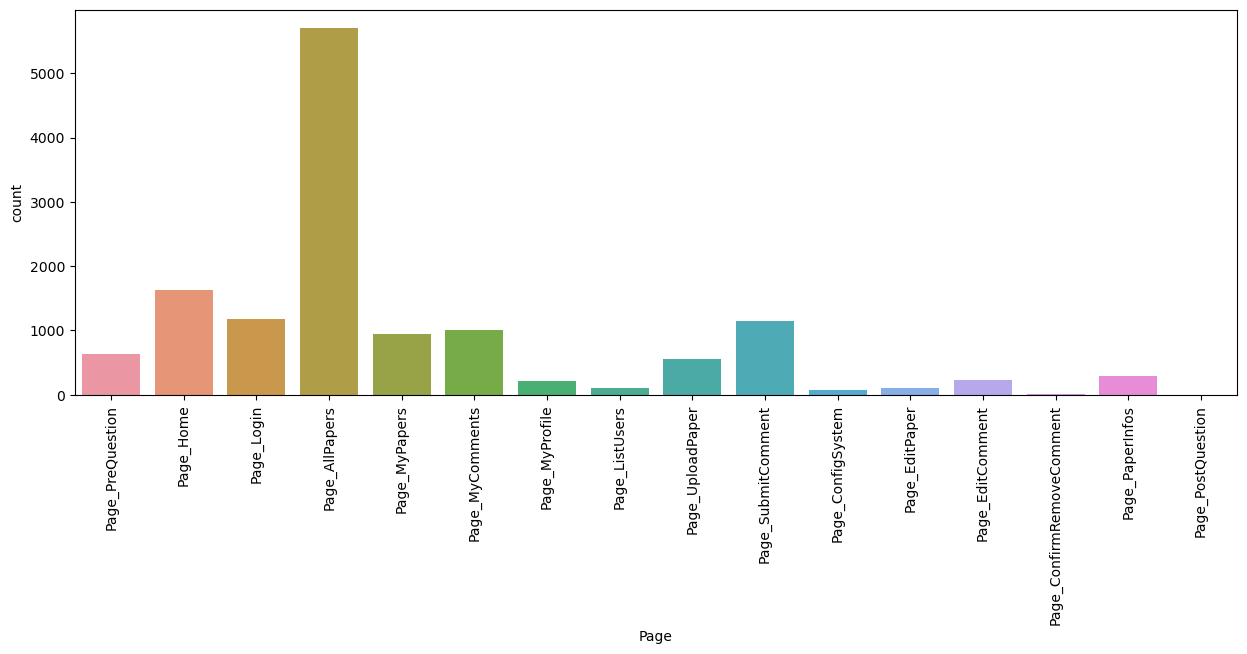

In [24]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation='vertical')
sns.countplot(x=df_completo.Page)

<Axes: xlabel='Page', ylabel='count'>

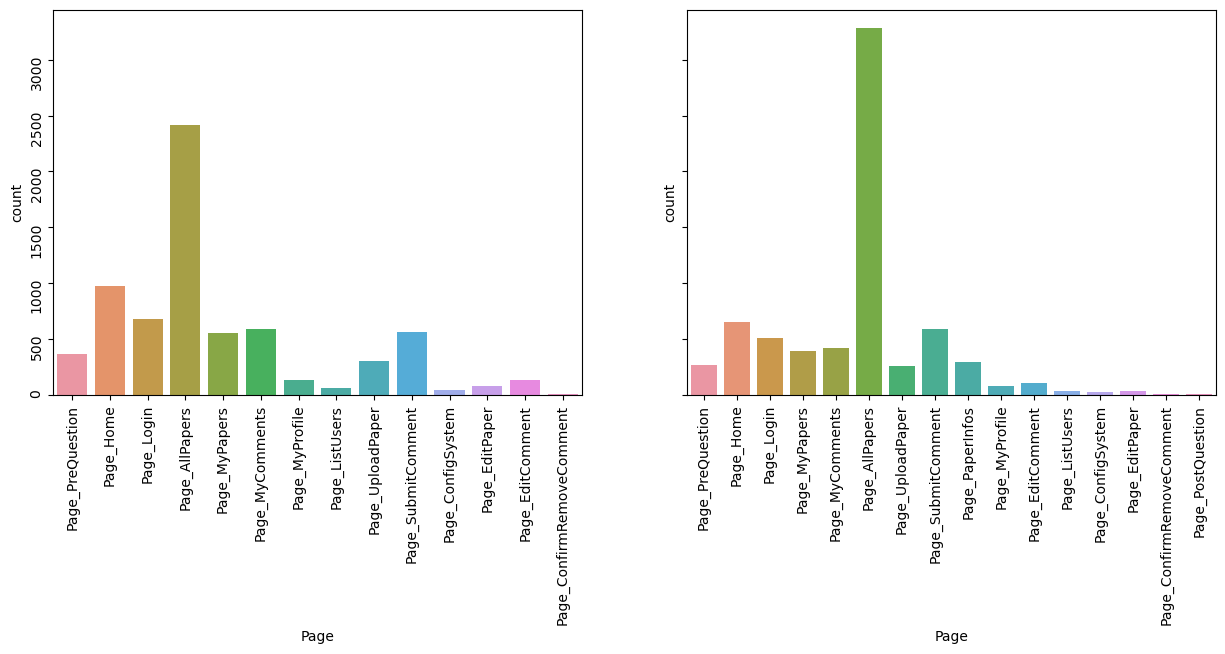

In [25]:
fig, axes = plt.subplots(1,2, figsize=(15,5), sharey="row", sharex="col")
axes[0].tick_params(labelrotation=90)
axes[1].tick_params(labelrotation=90)
sns.countplot(x=df_completo[df_completo.experimento == 1].Page, ax=axes[0])

sns.countplot(x=df_completo[df_completo.experimento == 2].Page, ax=axes[1])


El comportamiento es similiar en ambos experimentos

De acuerdo con el anterior gráfico Page_AllPapers es el sitio que ha tenido más acciones  para los usuarios

In [26]:
df_completo["periodo_dia"] = np.where((df_completo.Date.dt.hour >= 5) & (df_completo.Date.dt.hour < 12),"mañana","")
df_completo["periodo_dia"] = np.where((df_completo.Date.dt.hour >= 12) & (df_completo.Date.dt.hour < 19),"tarde", df_completo.periodo_dia)
df_completo["periodo_dia"] = np.where((df_completo.Date.dt.hour >= 19) & (df_completo.Date.dt.hour < 24), "noche", df_completo.periodo_dia)
df_completo.loc[df_completo.periodo_dia == "", "periodo_dia"] = "madrugada"

In [27]:
df_completo.periodo_dia.value_counts()

madrugada    5911
tarde        5166
noche        3006
mañana        356
Name: periodo_dia, dtype: int64

<Axes: title={'center': 'Comportamiento de los usuarios en cada sitio web durante el día'}, xlabel='Page', ylabel='count'>

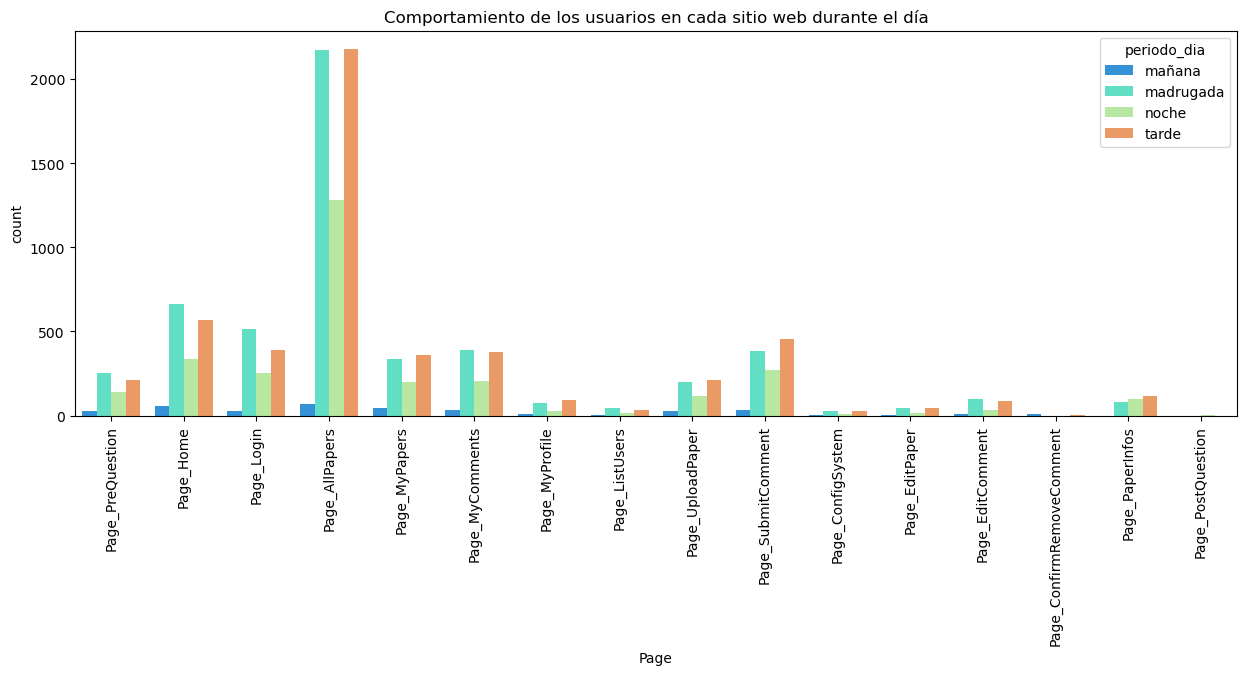

In [28]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation='vertical')
plt.title("Comportamiento de los usuarios en cada sitio web durante el día")
sns.countplot(x='Page',data=df_completo, palette='rainbow', hue='periodo_dia')

Es interesante que hay más acciones durante la madrugada (entre las 24 y 5), donde los sitios más visitados serían el Page_Home, Page_Login y Page_AllPapers

<Axes: title={'center': 'Actividades de los usuarios en cada sitio web'}, xlabel='Page', ylabel='count'>

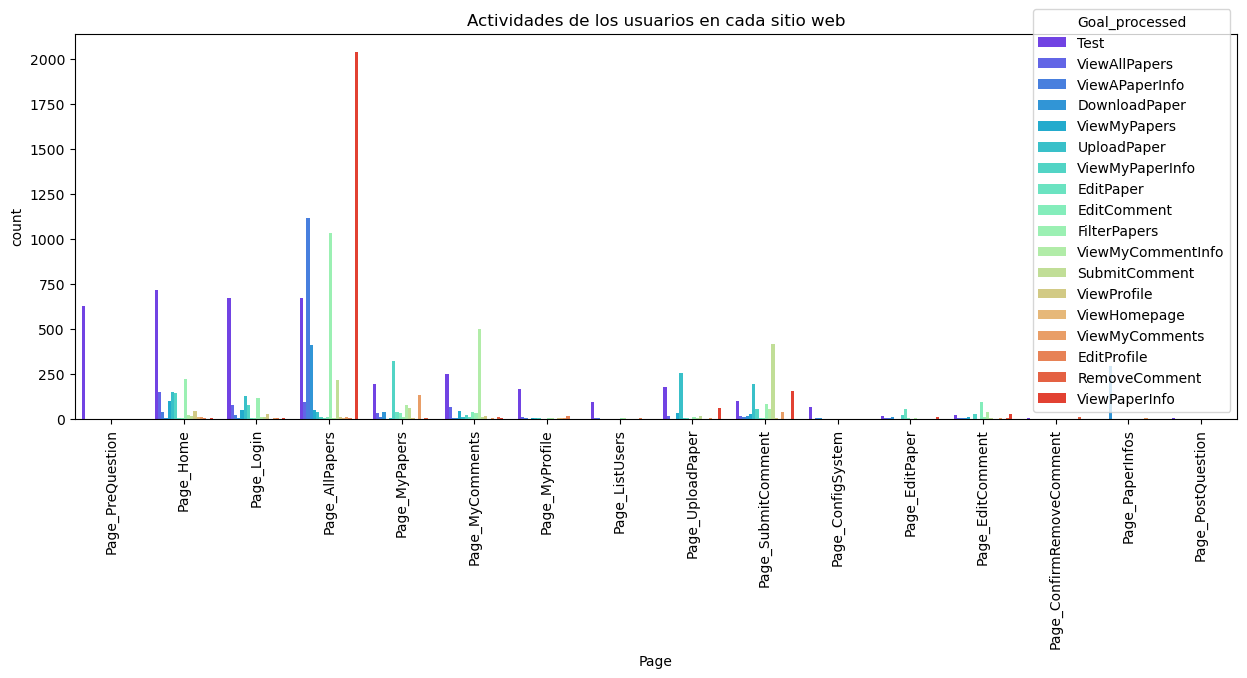

In [29]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation='vertical')
plt.title("Actividades de los usuarios en cada sitio web")
sns.countplot(x='Page',data=df_completo, palette='rainbow', hue='Goal_processed')

Voy a revisar las acciones de los usuarios frente a las tres páginas mencionadas

*Page_Login*

<Axes: title={'center': 'Acciones de los usuarios en la página de login'}, xlabel='Goal_processed', ylabel='count'>

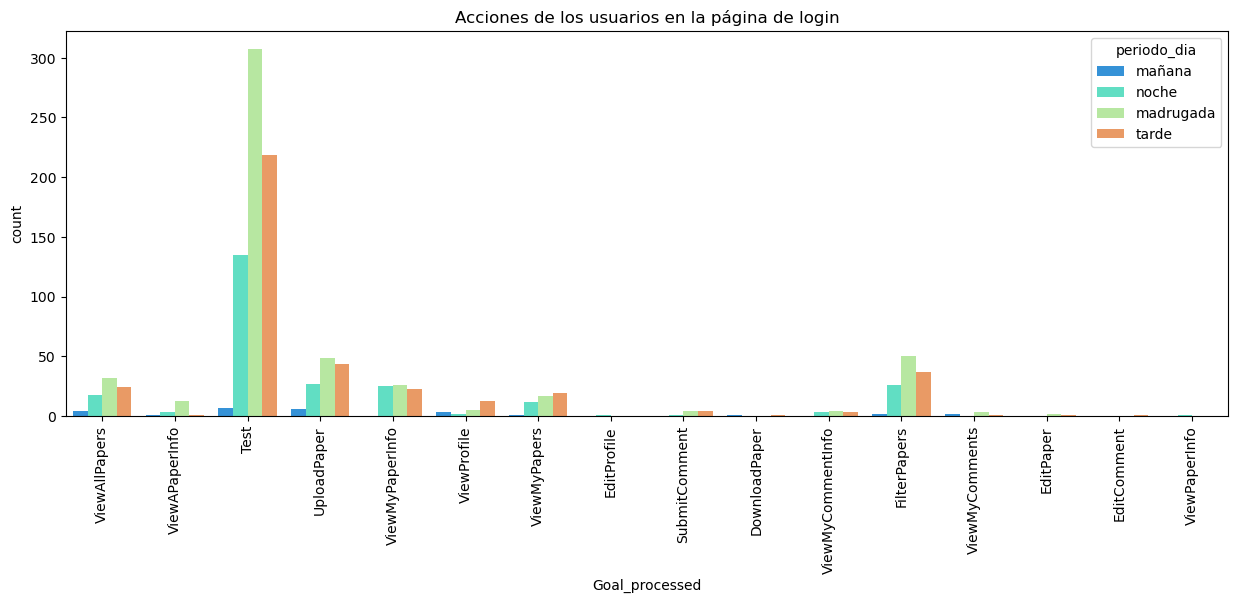

In [30]:
plt.figure(figsize=(15, 5))
plt.title("Acciones de los usuarios en la página de login")
plt.xticks(rotation='vertical')
sns.countplot(x='Goal_processed',data=df_completo[df_completo.Page == "Page_Login"], palette='rainbow', hue='periodo_dia')

El anterior gráfico nos permiter intuir que las acciones realizadas sobre la página de login fueron más de tipo de test en horas de la madrugada. 

<Axes: title={'center': 'Objetivo de acción de los usuarios y el tiempo'}, xlabel='Time Interval', ylabel='Goal_processed'>

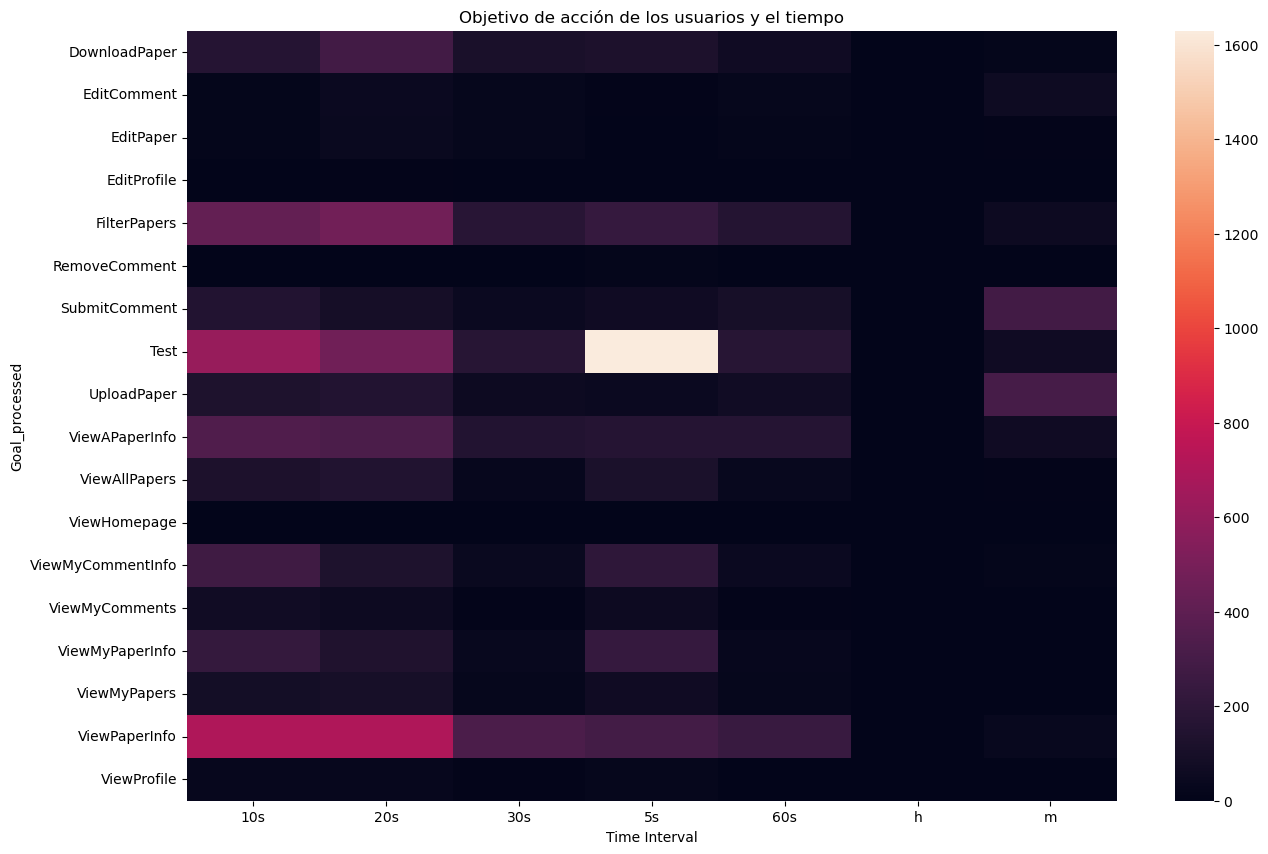

In [31]:
plt.figure(figsize=(15, 10))
plt.title("Objetivo de acción de los usuarios y el tiempo")
sns.heatmap(pd.crosstab(df_completo.Goal_processed,df_completo["Time Interval"]))

El anterior heatmap nos permite por el momento decir que las acciones de tipo Test no se demoran más de 5 segundos, a diferencia de otras acciones toman más tiempo relacionas a subir archivos o comentarios.

<Axes: xlabel='periodo_dia', ylabel='Observation'>

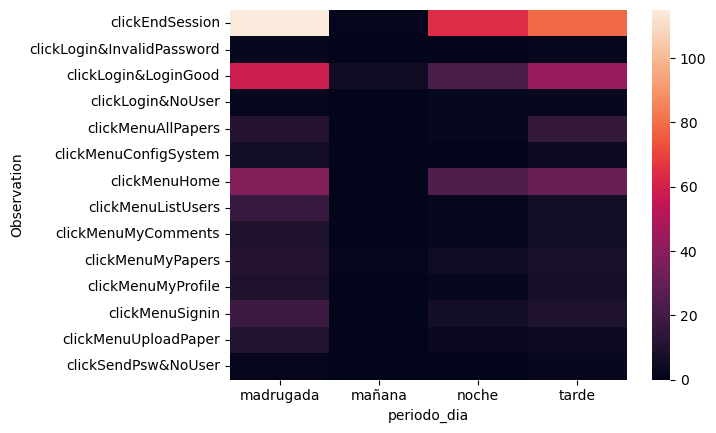

In [32]:
filtro = df_completo[(df_completo.Page == "Page_Login") & (df_completo.Goal_processed == "Test")].copy()
sns.heatmap(pd.crosstab(filtro.Observation,filtro.periodo_dia))

In [33]:
df_completo[(df_completo.Page == "Page_Login") & (df_completo.Goal_processed == "Test")].Content.unique()[:15]

array([nan,
       '[Login ID]user015 [Password]7028c7 [Message]Login Successful',
       '[Login ID]user023 [Password]33c403 [Message]Login Successful',
       '[Login ID]user025 [Password]1bc978 [Message]Login Successful',
       '[Login ID]user035 [Password]ab1e2d [Message]Login Successful',
       '[Login ID]user051 [Password]1c5edd [Message]Login Successful',
       '[Login ID]user053 [Password]d33709 [Message]Login Successful',
       '[Login ID]user056 [Password]b5912a [Message]Login Successful',
       '[Login ID]user071 [Password]a4b0bc [Message]Login Successful',
       '[Login ID]user088 [Password]9ca274 [Message]Invalid password',
       '[Login ID]user083 [Password]9ca274 [Message]Login Successful',
       '[Login ID]user090 [Password]01437a [Message]Login Successful',
       '[Login ID]user092 [Password]3d7d33 [Message]Login Successful',
       '[Login ID]user095 [Password]55c4a8 [Message]Login Successful',
       '[Login ID]user095 [Password]ed55aa [Message]Invalid passw

Existe un problema de cifrado para la transferencia de los datos de login

<Axes: xlabel='Time Interval', ylabel='Observation'>

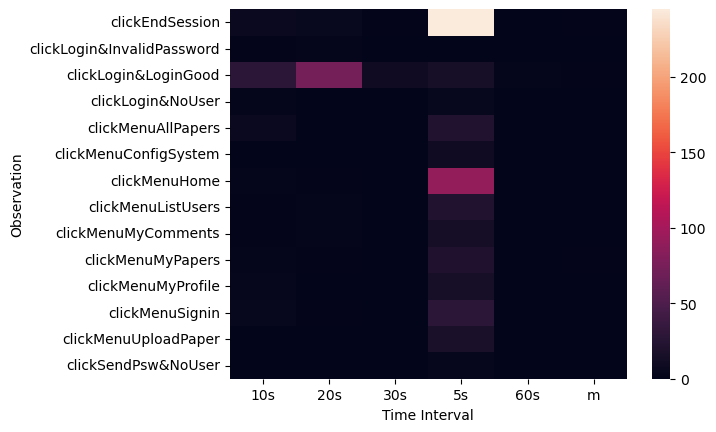

In [34]:
filtro = df_completo[(df_completo.Page == "Page_Login") & (df_completo.Goal_processed == "Test")].copy()
sns.heatmap(pd.crosstab(filtro.Observation,filtro["Time Interval"]))

Podemos deducir que la actividad que más toma tiempo desde la página de login es el fin de sesión, a diferencia del login que toma alrededor de 20 segundos y las otras actividades toman más tiempo.

*Page_Home*

<Axes: title={'center': 'Acciones de los usuarios en la página de home'}, xlabel='Goal_processed', ylabel='count'>

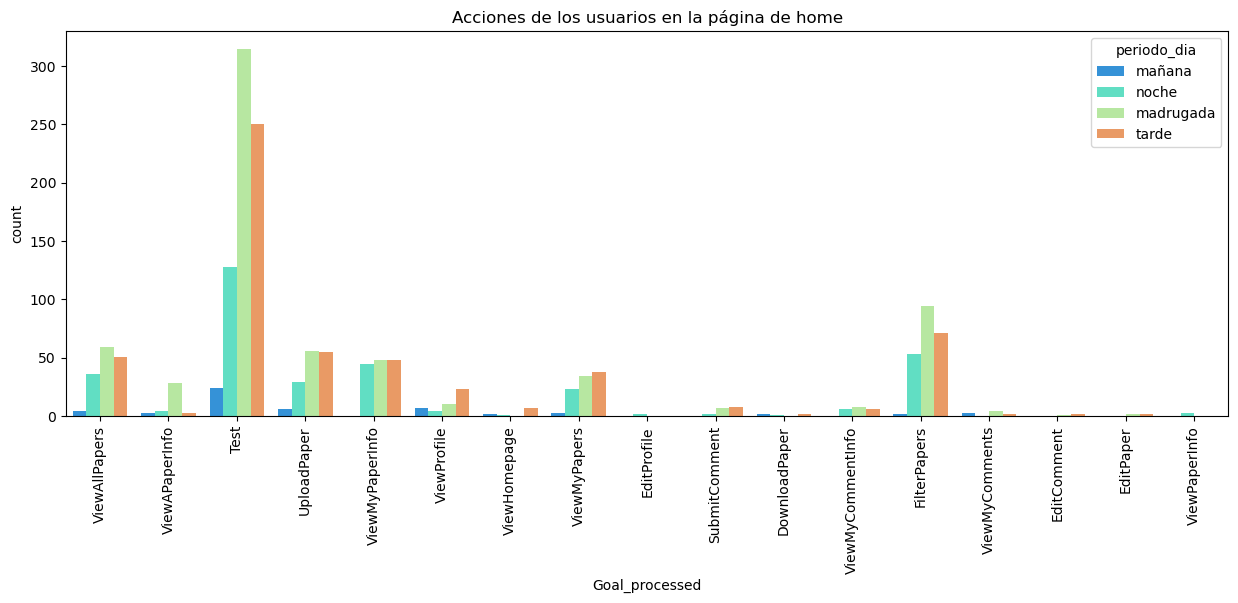

In [35]:
plt.figure(figsize=(15, 5))
plt.title("Acciones de los usuarios en la página de home")
plt.xticks(rotation='vertical')
sns.countplot(x='Goal_processed',data=df_completo[df_completo.Page == "Page_Home"], palette='rainbow', hue='periodo_dia')

Tenemos otro caso donde se realizan mayor cantidad de casos de test y en horas de la madrugada 

In [36]:
df_completo[(df_completo.Page == "Page_Home") ].Action.unique()

array(['click(Menuopt_AllPapers)', 'click(Btn_EndSession)',
       'click(Menuopt_UploadPaper)', 'click(Menuopt_ListUsers)',
       'click(Menuopt_MyProfile)', 'click(Menuopt_ConfigSystem)',
       'click(Menuopt_MyPapers)', 'click(Menuopt_Home)',
       'click(Menuopt_Signout)', 'click(Menuopt_Signin)',
       'click(Link_ICSE)', 'click(Link_FairUse)',
       'click(Menuopt_MyComments)', 'click(Link_Contact)'], dtype=object)

*Page_AllPapers*

<Axes: title={'center': 'Acciones de los usuarios en la página de todos los papers'}, xlabel='Goal_processed', ylabel='count'>

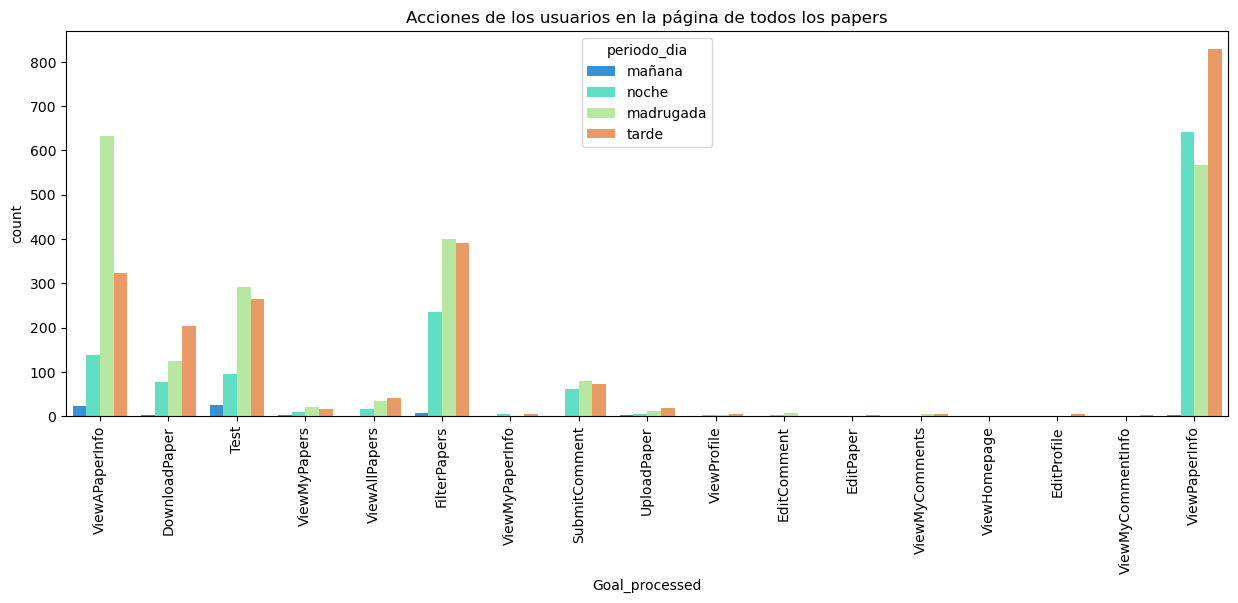

In [37]:
plt.figure(figsize=(15, 5))
plt.title("Acciones de los usuarios en la página de todos los papers")
plt.xticks(rotation='vertical')
sns.countplot(x='Goal_processed',data=df_completo[df_completo.Page == "Page_AllPapers"], palette='rainbow', hue='periodo_dia')

Como podemos evidenciar en este último plot, la mayoría de usuarios no realizan test, tienen como mayor objetivo ver información del paper y lo realizan en horas de la tarde hasta la madrugada. 

Page_SubmitComment

<Axes: title={'center': 'Acciones de los usuarios en la página de todos los papers'}, xlabel='Goal_processed', ylabel='count'>

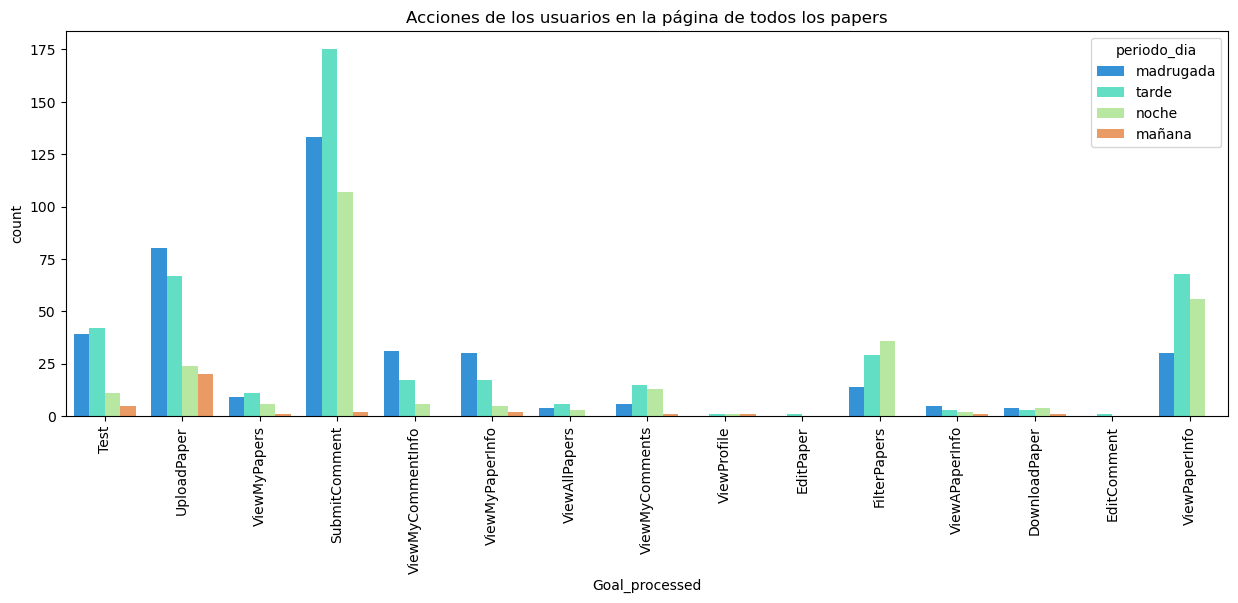

In [38]:
plt.figure(figsize=(15, 5))
plt.title("Acciones de los usuarios en la página de todos los papers")
plt.xticks(rotation='vertical')
sns.countplot(x='Goal_processed',data=df_completo[df_completo.Page == "Page_SubmitComment"], palette='rainbow', hue='periodo_dia')

In [39]:
df_completo[(df_completo.Content.isna()!=True) & (df_completo.Content.str.contains("<script"))].Content[1936]

"[paper ID] 1418847421#3#\n[DTBS_Overall] 3#3#\n[FORM_Overall] 3#3#\n[FORM_Categories] Big Data Analytics and Knowledge Management;#3#\n[DTBS_Categories] Big Data Analytics and Knowledge Management;#3#\n[DTBS_Recommendation] Yes#3#\n[FORM_Recommendation] Yes#3#\n[DTBS_ProblemSolved] Thornton May says, ?€?Initiatives such as the use of RFID tags and smart metering are driving an ever greater need to deal with the torrent of data in nearreal time. This, coupled with the need and drive to be more agile and deliver insight quicker, is putting tremendous pressure on organizations to build the necessary infrastructure and skill base to react quickly enough.?€?#3#\n[FORM_ProblemSolved] Thornton May says, ?€?Initiatives such as the use of RFID tags and smart metering are driving an ever greater need to deal with the torrent of data in nearreal time. This, coupled with the need and drive to be more agile and deliver insight quicker, is putting tremendous pressure on organizations to build the n

Tal vez el sitio web sea propenso a vulnerabilidades de XSS ya el comentario muestra código HTML y Javascript adjunto. 

***

In [40]:
print(df_completo.Date.min())
print(df_completo.Date.max())

2014-09-16 08:17:10
2015-01-17 23:26:08


Voy a realizar ahora un análisis temporal de los casos teniendo presente que las interacciones de los usuarios se realizo por varios meses.

In [41]:
df_completo["dia"] = df_completo.Date.dt.dayofweek

<Axes: title={'center': 'Comportamiento de los usuarios en cada sitio web durante el día'}, xlabel='dia', ylabel='count'>

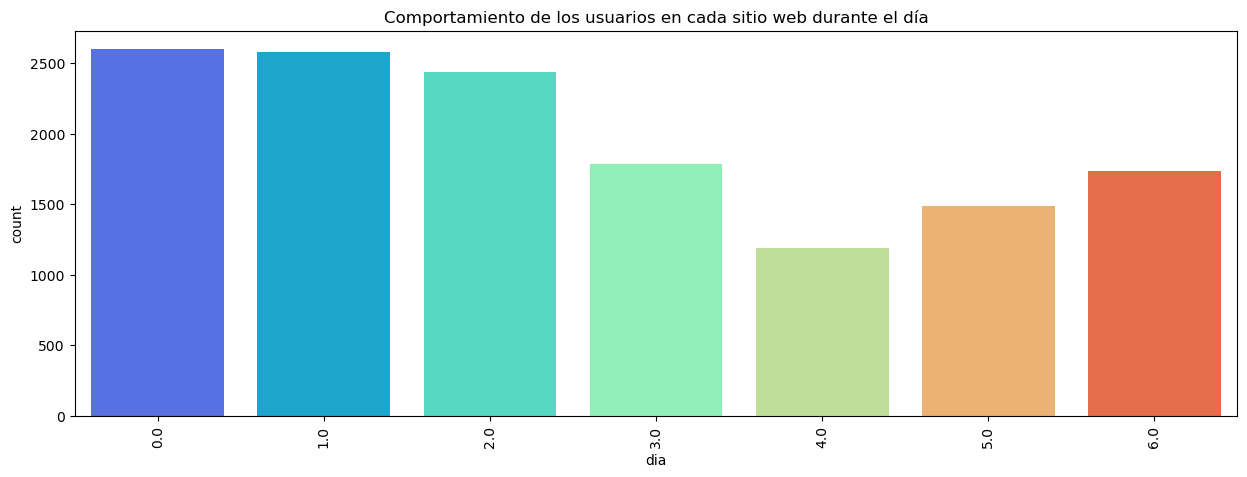

In [42]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation='vertical')
plt.title("Comportamiento de los usuarios en cada sitio web durante el día")
sns.countplot(x='dia',data=df_completo, palette='rainbow')

El anterior plot nos permite conocer que los días que mayor tuvieron interacciones fueron entre lunes a miercoles 

<Axes: title={'center': 'Comportamiento de los usuarios en cada sitio web durante el día'}, xlabel='dia', ylabel='count'>

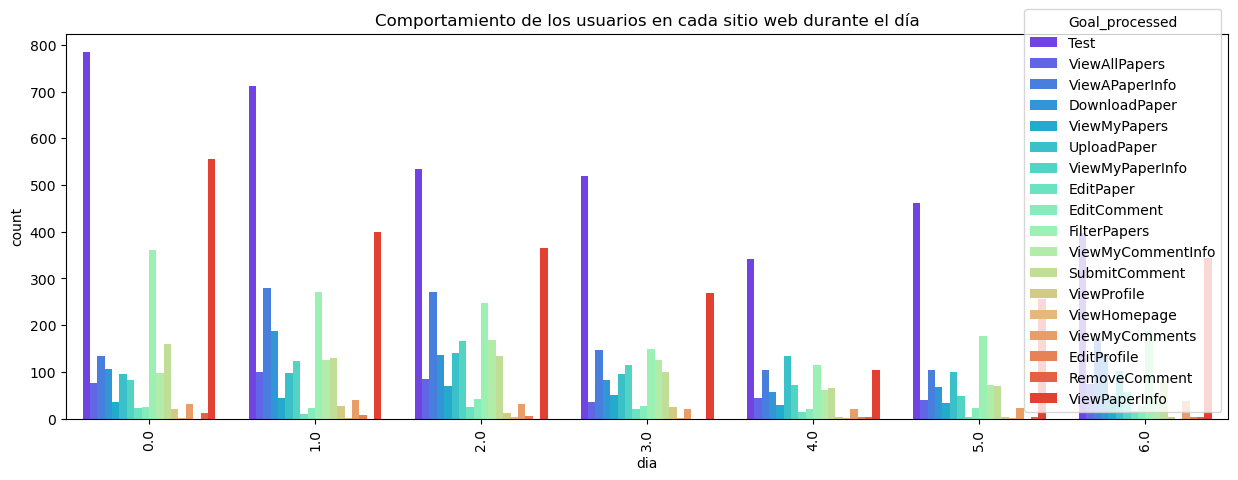

In [43]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation='vertical')

plt.title("Comportamiento de los usuarios en cada sitio web durante el día")
sns.countplot(x='dia',data=df_completo, palette='rainbow', hue="Goal_processed")

Podemos encontrar que las acciones más realizadas fueron con el objetivo de test, luego va la revisión de la información del paper y le sigue las opcioens de filtro de articulos.

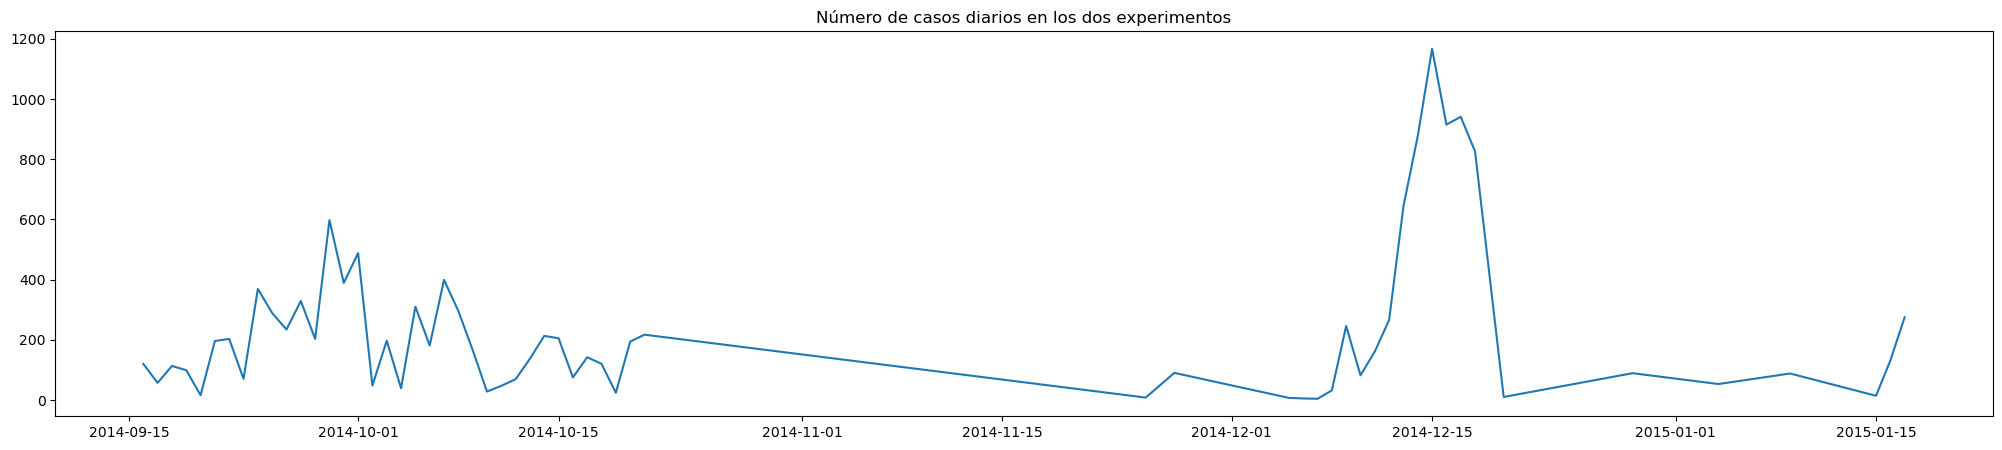

In [44]:
contador = df_completo.groupby(df_completo.Date.dt.floor('d')).size().reset_index(name='casos')
contador.index =  contador.Date
del contador["Date"]
plt.figure(figsize=(25, 5))
plt.title("Número de casos diarios en los dos experimentos")
plt.plot(contador)

El anterior insumo nos permite ver como las peticiones presentaron de septiembre hasta diciembre una reducción de peticiones, sin embargo durante diciembre se presento el mayor pico de casos

<Axes: title={'center': 'Número de casos diarios por objetivo del usuario'}, xlabel='Date', ylabel='casos'>

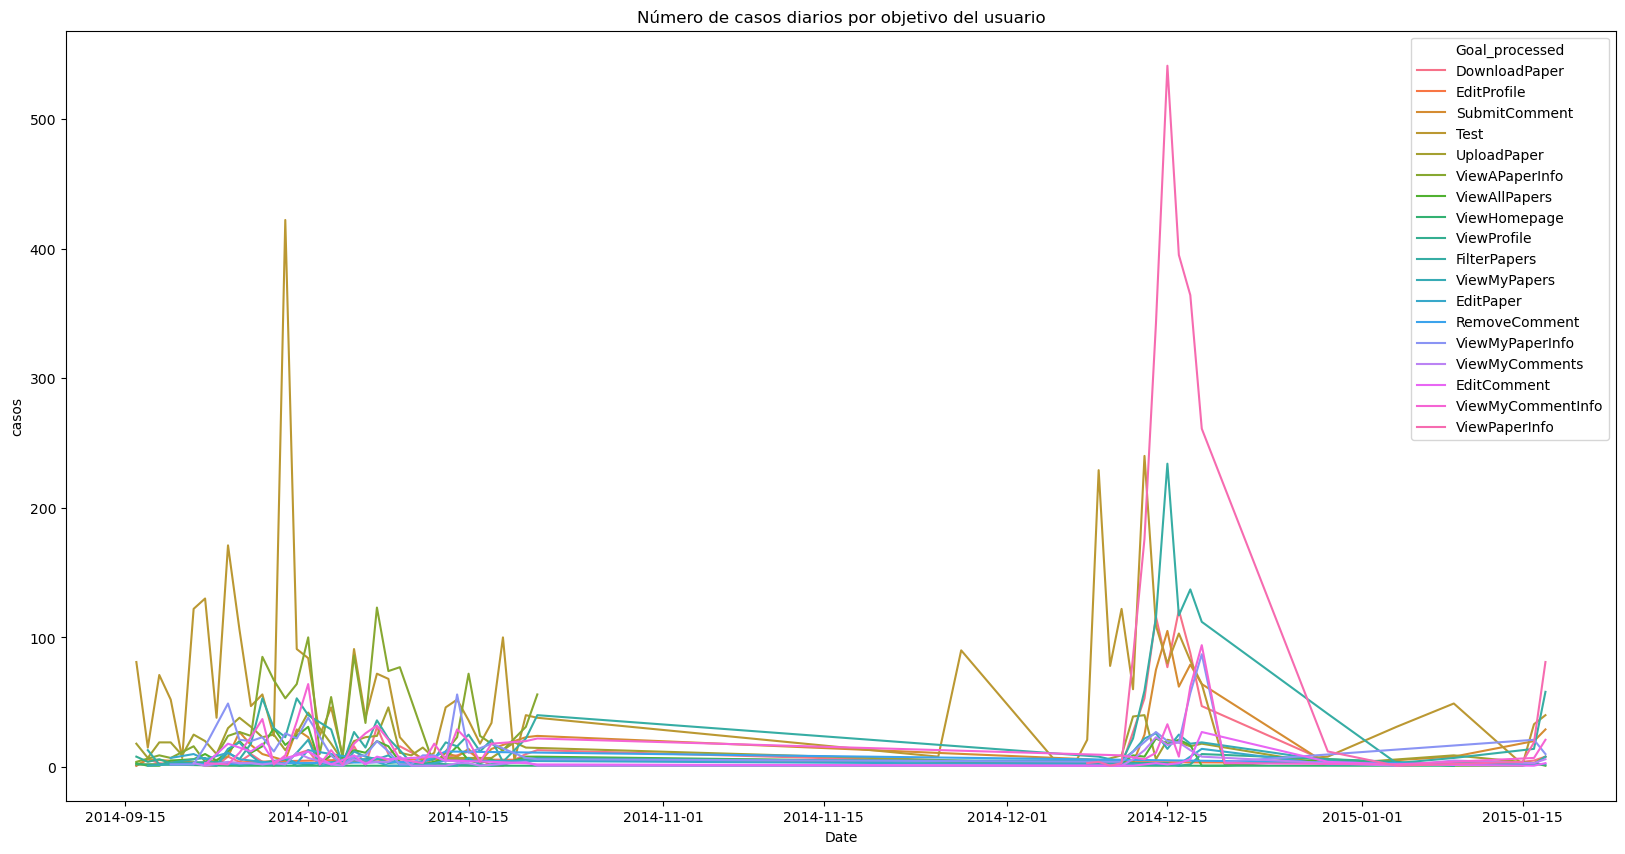

In [45]:
contador = df_completo.groupby([df_completo.Date.dt.floor('d'),df_completo.Goal_processed]).size().reset_index(name='casos')
contador.index =  contador.Date
plt.figure(figsize=(20, 10))
plt.title("Número de casos diarios por objetivo del usuario")
sns.lineplot(data=contador, x="Date", y="casos", hue="Goal_processed")

Con lo anterior podemos ver que el pico en diciembre es dado por una descarga masiva de papers. Por otra parte, podemos encontrar que hay un alto número casos de testeo a principios de septiembre. 

<Axes: title={'center': 'Número de casos diarios por usuario'}, xlabel='Login ID', ylabel='count'>

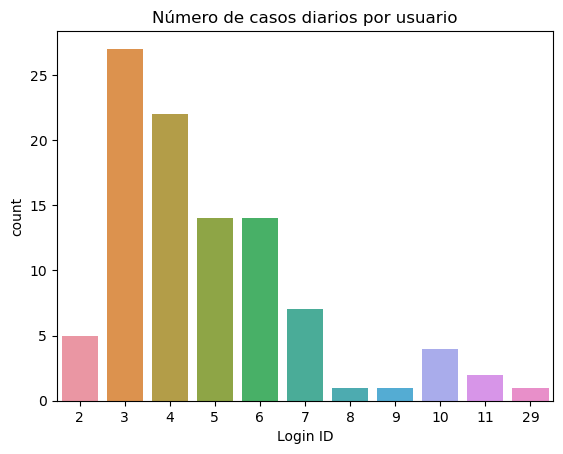

In [46]:
contador = df_completo.groupby([df_completo.Date.dt.floor('d'),df_completo['Login ID']]).size().reset_index(name='casos')
contador.index =  contador.Date
plt.title("Número de casos diarios por usuario")
sns.countplot(x=contador.sort_values(by="casos", ascending=False)["Login ID"].value_counts())

In [47]:
contador.sort_values(by="casos", ascending=False)["Login ID"].value_counts()[:10]

user049    29
user051    11
user136    11
user037    10
user083    10
user071    10
user026    10
user048     9
user135     8
user015     7
Name: Login ID, dtype: int64

Podemos encontrar el top 10 de usuarios que más interacturaron diariamente con el sitio web

In [48]:
contador.sort_values(by="casos", ascending=False)["Login ID"].value_counts()[-10:]

user255    3
user218    3
user191    3
user063    3
user108    3
user186    2
user074    2
user080    2
user211    2
user057    2
Name: Login ID, dtype: int64

Encontramos los usuarios que no interactuaron diariamente con el sistema.

*user049*

<Axes: title={'center': 'Número de eventos realizados por el Usuario más activo user049'}, xlabel='Goal_processed', ylabel='count'>

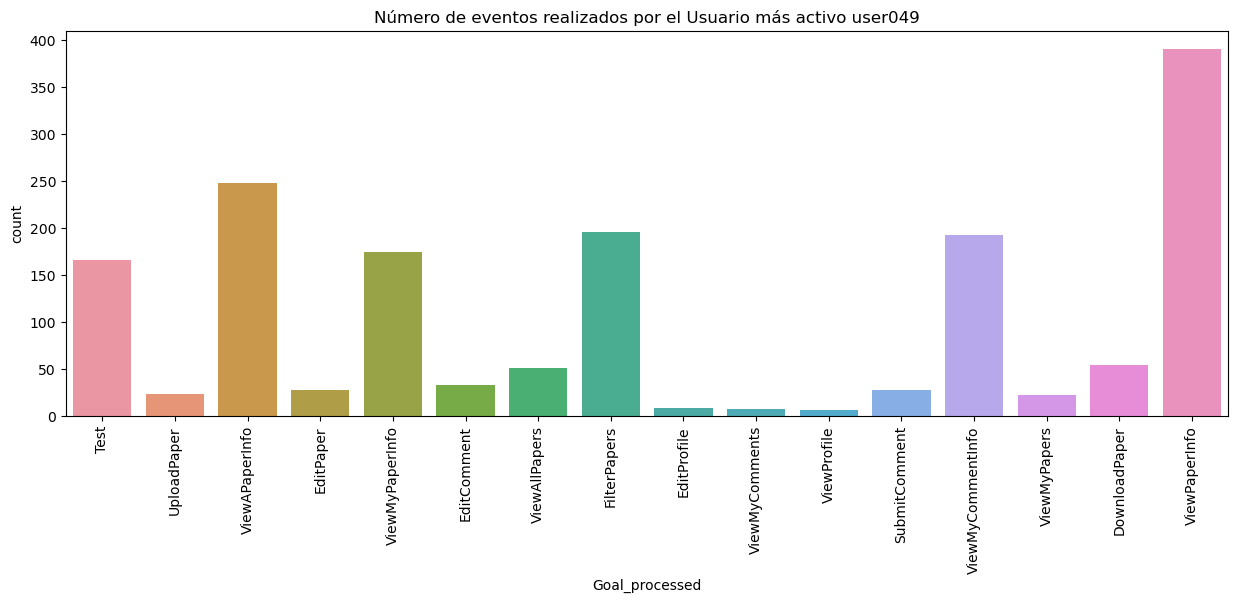

In [49]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation='vertical')
plt.title("Número de eventos realizados por el Usuario más activo user049")
sns.countplot(x=df_completo[df_completo["Login ID"]=="user049"].Goal_processed)

El usuario más activo tiene un comportamiento con objetivos más diversos y con tendencia a revisar los papers

*user037*

<Axes: title={'center': 'Número de eventos para el Usuario user037'}, xlabel='Goal_processed', ylabel='count'>

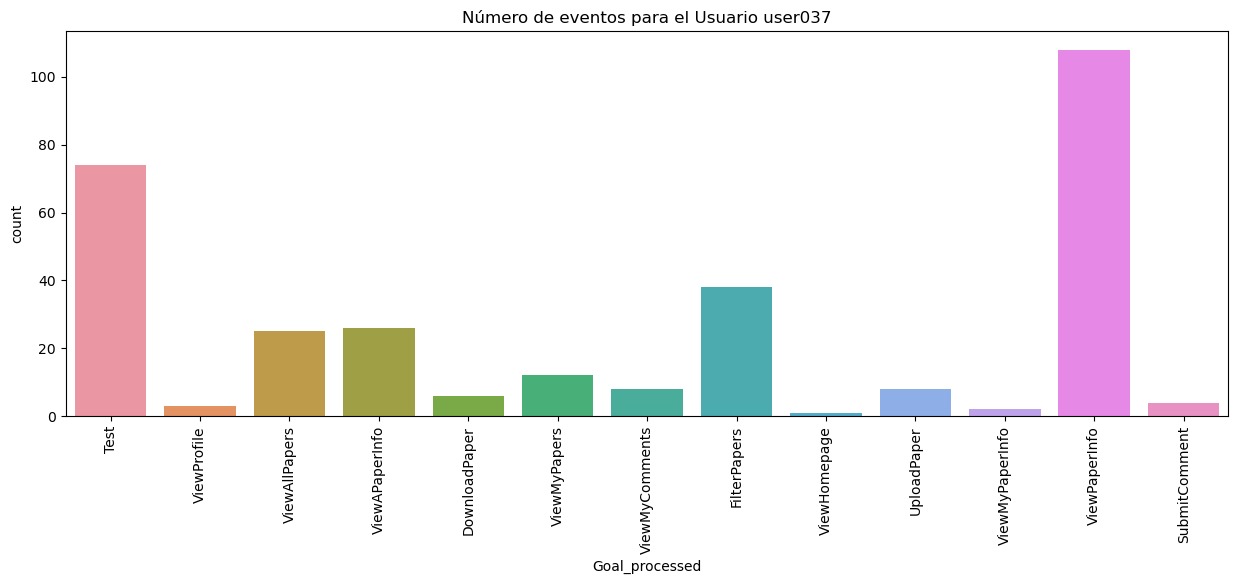

In [50]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation='vertical')
plt.title("Número de eventos para el Usuario user037")
sns.countplot(x=df_completo[df_completo["Login ID"]=="user037"].Goal_processed)

El user037 tiende a revisar también papers pero ejecuta más acciones de tipo test.

*user255*

<Axes: title={'center': 'Número de eventos realizados por el Usuario menos activo user255'}, xlabel='Goal_processed', ylabel='count'>

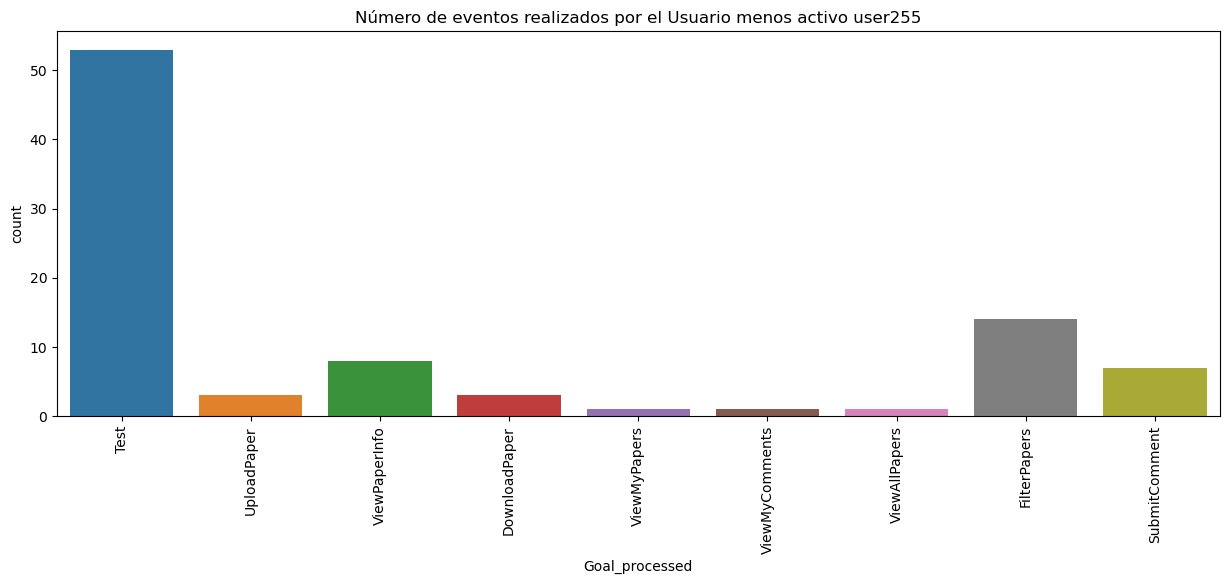

In [51]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation='vertical')
plt.title("Número de eventos realizados por el Usuario menos activo user255")
sns.countplot(x=df_completo[df_completo["Login ID"]=="user255"].Goal_processed)

El user255 si tiene más tendencia a realizar actividades de test

*user057*

<Axes: title={'center': 'Número de eventos realizados para un usuario menos activo user255'}, xlabel='Goal_processed', ylabel='count'>

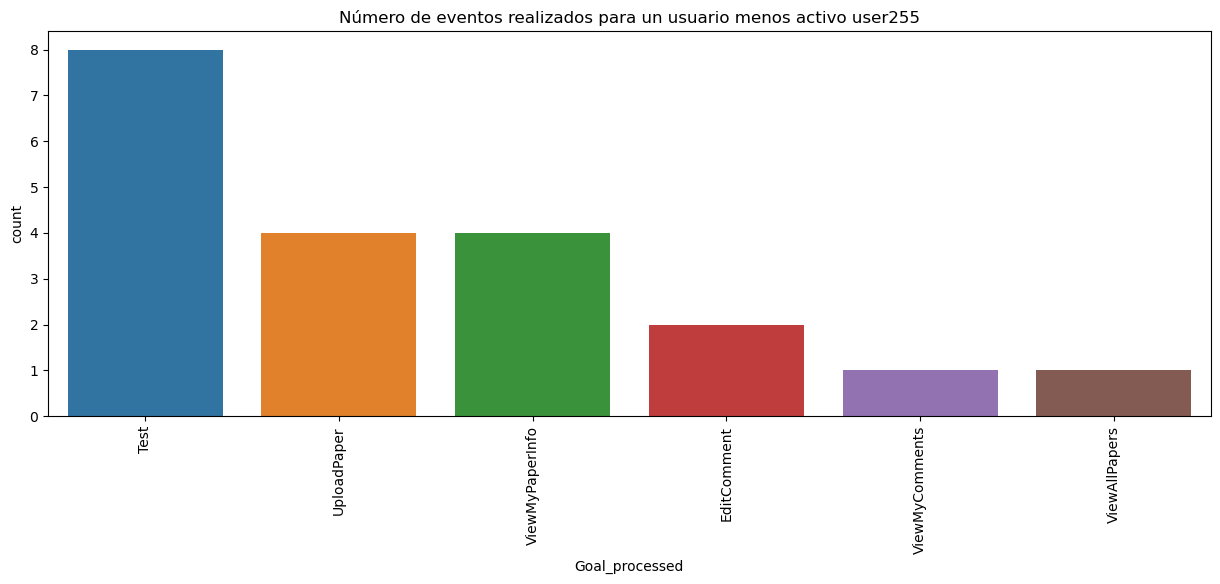

In [52]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation='vertical')
plt.title("Número de eventos realizados para un usuario menos activo user255")
sns.countplot(x=df_completo[df_completo["Login ID"]=="user057"].Goal_processed)

El user057 tiene más tendencia a desarrollar test.

Al parecer los usuarios menos activos tienen como objetivo realizar más testeos.

Hay algunos sitios del sistema cuentan con posibles vulnerabilides y alto trafico de visitas, procedere a crear una variable que permita conocer el riesgo teniendo presente los siguientes criterios:

*Riesgo alto*
+ Page_Login: Cuenta con un alto volumen de solicitudes y presenta una exposición de datos sensibles.
+ Page_SubmitComment y Page_EditComment: al parecer los comentarios no filtran código que podría ser inyectado para fines maliciosos.

*Riesgo medio*
+ Page_UploadPaper y Page_EditPaper: No se puede verificar si hay un filtro de tipo de archivo y si se generan análisis una vez el sistema los recibe.
+ Page_ConfigSystem: No se puede determinar los controles a nivel de rol y los privilegios.

*Riesgo bajo*: No presenta contenido y contexto que nos permita determinar algún riesgo
+ Page_PostQuestion, Page_PreQuestion, Page_Home, Page_AllPapers, Page_MyPapers, Page_MyComments, Page_MyProfile, Page_ListUsers, Page_PaperInfos, Page_EditPaper, Page_ConfirmRemoveComment

In [53]:
df_completo["riesgo"] = np.where(df_completo.Page.isin(["Page_Login", "Page_SubmitComment", " Page_EditComment"]), "alto", "")
df_completo["riesgo"] = np.where(df_completo.Page.isin(["Page_UploadPaper", "Page_EditPaper", " Page_ConfigSystem"]), "medio", df_completo["riesgo"])
df_completo.loc[df_completo.riesgo == "", "riesgo"] = "bajo"

<Axes: title={'center': 'Número de acciones registradas y su nivel de riesgo'}, xlabel='riesgo', ylabel='count'>

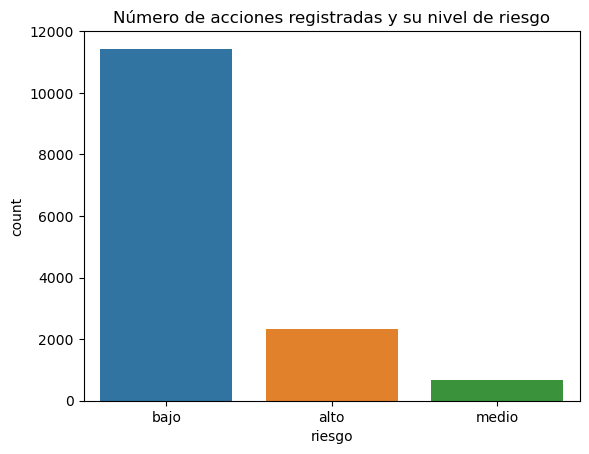

In [54]:
plt.title("Número de acciones registradas y su nivel de riesgo")
sns.countplot(x=df_completo.riesgo)

El anterior insumo me permitirá darle pririoridad a las alertas

Dado a que contamos con algunas acciones que implican un tiempo de ejecución del sistema (reflejado en la variable 'Time Interval' utilizaré los valores cualitativos y transformarlos en una nueva variable cuantitativa con valores aleatorios partiendo que se encuentran en los rangos asignados. Los valores (4528) en nan no serán tenidos en cuenta, es importante mencionar que la imputación se puede practicar con mojores técnicas, por ejemplo un modelo de forecasting. 

In [55]:
df_completo["tiempo_creado"] = np.nan

In [56]:
copia = df_completo.copy()

In [57]:
def myfun30(row):
    return np.random.randint(21,30)

def myfun20(row):
    return np.random.randint(11,20)

def myfunmin(row):
    return np.random.randint(61,3600)

def myfun60(row):
    return np.random.randint(31,60)

def myfun5(row):
    return np.random.randint(1,5)

def myfun10(row):
    return np.random.randint(6,10)

def myfunh(row):
    return np.random.randint(3600,7200)

df_completo.loc[df_completo['Time Interval']=="30s", "tiempo_creado"] = df_completo[df_completo['Time Interval']=="30s"].apply(myfun30,axis=1).copy()
df_completo.loc[df_completo['Time Interval']=="20s", "tiempo_creado"] = df_completo[df_completo['Time Interval']=="20s"].apply(myfun20,axis=1).copy()
df_completo.loc[df_completo['Time Interval']=="m", "tiempo_creado"]  = df_completo[df_completo['Time Interval']=="m"].apply(myfunmin,axis=1).copy()
df_completo.loc[df_completo['Time Interval']=="60s", "tiempo_creado"]  = df_completo[df_completo['Time Interval']=="60s"].apply(myfun60,axis=1).copy()
df_completo.loc[df_completo['Time Interval']=="10s", "tiempo_creado"]  = df_completo[df_completo['Time Interval']=="10s"].apply(myfun5,axis=1).copy()
df_completo.loc[df_completo['Time Interval']=="5s", "tiempo_creado"]  = df_completo[df_completo['Time Interval']=="5s"].apply(myfun10,axis=1).copy()
df_completo.loc[df_completo['Time Interval']=="h", "tiempo_creado"]  = df_completo[df_completo['Time Interval']=="h"].apply(myfunh,axis=1).copy()

<Axes: title={'center': 'Tiempo entre acciones consecutivas de los usuarios'}, xlabel='tiempo_creado', ylabel='Count'>

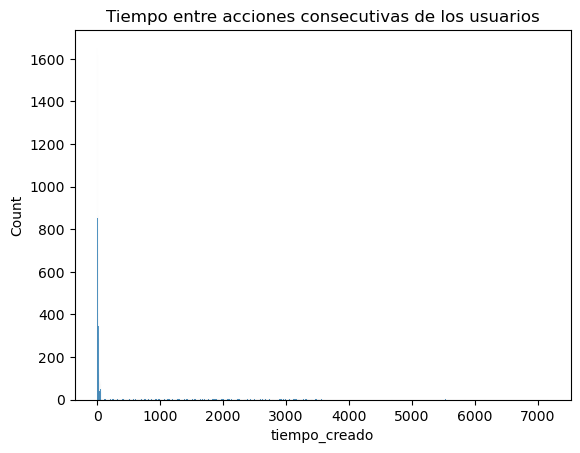

In [58]:
plt.title("Tiempo entre acciones consecutivas de los usuarios")
sns.histplot(df_completo.tiempo_creado)

<Axes: title={'center': 'Filtro del tiempo entre acciones consecutivas de los usuarios'}, xlabel='tiempo_creado', ylabel='Count'>

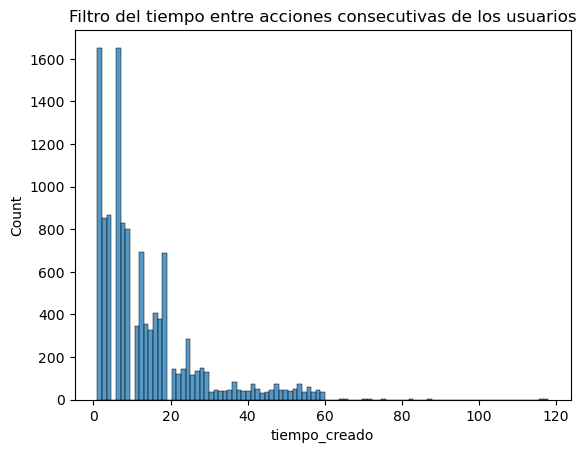

In [59]:
plt.title("Filtro del tiempo entre acciones consecutivas de los usuarios")
sns.histplot(df_completo[df_completo.tiempo_creado < 120].tiempo_creado)

Lo anterior nos dice que tenemos acciones que toman más de dos horas entre los puntos de tiempo de acciones consecutivas del usuario y hay una gran mayoría que no están más de 20 segundos.

In [60]:
df_completo = df_completo.merge(contador.loc[:,["Login ID", "casos"]], how="inner").copy()


**Objetivo 3 desarrollado**✔️

***

## Modelamiento

Con el fin de proponer y testear un modelo de detección de anomalías partiré de las siguientes hipótesis para definir un comportamiento normal teniendo presente los hallazgos encontrados en el EDA.
+ El dataset incluira las anomalías para la construcción del modelo, es decir, que no filtrare datos ya que se desconocen los casos de anomalías
+ Se desconoce el comportamiento atipico a nivel de negocio
+ No hay un resultado previo que permita comparar los resultados del modelo
+ De acuerdo al EDA existen acciones etiquetadas que permiten conocer el comportamiento tipico y otros que fueron etiquetados como casos de testeo. A continuación, definire algunas ideas obtenidas del proceso que podrían servir para el modelamiento:
    + Los usuarios suelen revisar el sistema entre lunes a miercoles, el día podría ser una variable a considerar
    + El tiempo de visitas al sistema (ventana de tiempo) podría ser un determinante 
    + Hay páginas que tienen mayor flujo de visitas, algunas de las anteriores tienen vulnerabilidades que pueden ser aprovechadas 
    

#### Pimer modelo

<Axes: title={'center': 'Proporción de eventos diarios para el total de usuarios'}, xlabel='casos'>

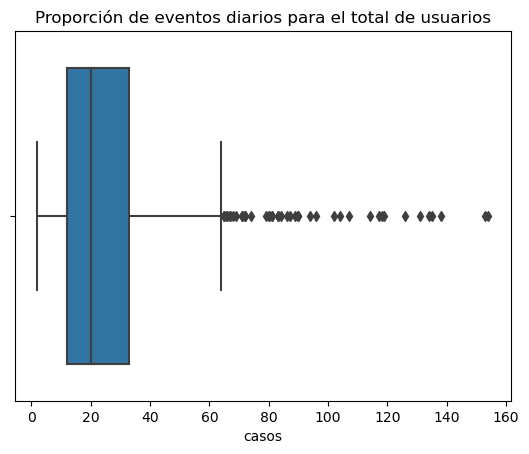

In [61]:
plt.title("Proporción de eventos diarios para el total de usuarios")
sns.boxplot(x=contador.casos)

Con el anterior insumo creare una nueva variable que me permita identificar la actividad por usuario a través de la siguiente regla:
+ Usuarios activos: aquellos que sean datos atipicos superiores al quartil 0.75 + iqr
+ Usuarios normales: aquellos que estan entre el q1 y el quartil 0.75 + iqr
+ Usuarios atipicos: aquellos menores al q1

In [62]:
q3, q1 = np.percentile(contador.casos, [75 ,25])
iqr = q3 - q1
med = contador.casos.mean()
df_completo["tipo_usuario"] = np.where(df_completo.casos >= (q3+iqr), "activo", "")
df_completo["tipo_usuario"] = np.where((df_completo.casos >= q1) & (df_completo.casos < (q3+iqr)), "normal", df_completo.tipo_usuario)
df_completo.loc[df_completo.tipo_usuario == "", "tipo_usuario"] = "atipico"

<Axes: title={'center': 'Casos detectados por el modelo estadistico'}, xlabel='tipo_usuario', ylabel='count'>

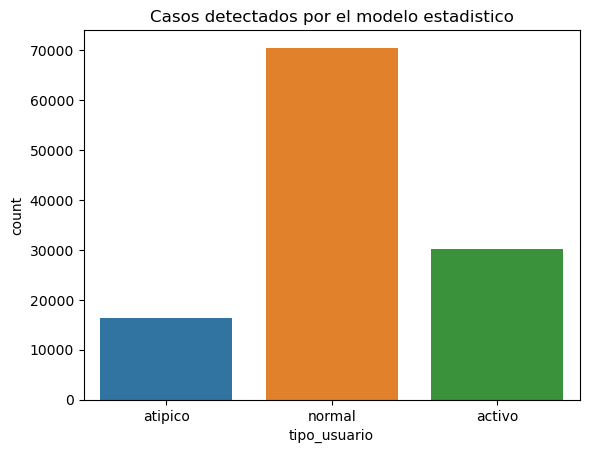

In [63]:
plt.title("Casos detectados por el modelo estadistico")
sns.countplot(x=df_completo.tipo_usuario)

La anterior aproximación podría considerarse como una **primera propuesta de modelo utilizando el comportamiento diario de los usuarios y aplicación estadistica** 

#### Segundo modelo

El siguiente modelo utiliza las variables del nivel de riesgo de un sitio del sistema web y lo relaciona con la cantidad de acciones de los usuarios bajo una ventana de tiempo $t$ minutos:

$ N:$
 número de acciones por día durante los experimentos uno y dos 
 
$ R: $ Nivel de riesgo del sitio estudiado

$ t: $ tiempo en minutos para calcular el tiempo previo a la fecha dada 

$
 \left.
    \begin{array} \\
        1 \\
        0
    \end{array}
\right \}= F(datos, fecha)= \sum_{a=0}^{a_{max}}\sum_{t=0}^{t_{max}} N_{t, a} * R
$


El siguiente modelo se propone como un mecanismo para detección de ataques de denegación de servicio, ataques de fuerza bruta entre otros que impliquen un alto pico de consultas en los últimos 15 segundos.

In [64]:
# los siguientes son los pesos cuantitativos que dare para cada nivel de riesgo
df_completo["riesgo_cuantitativo"] = np.where(df_completo.Page.isin(["Page_Login", "Page_SubmitComment", " Page_EditComment"]), 5, 10)
df_completo["riesgo_cuantitativo"] = np.where(df_completo.Page.isin(["Page_UploadPaper", "Page_EditPaper", " Page_ConfigSystem"]), 3, df_completo["riesgo_cuantitativo"])
df_completo.loc[df_completo.riesgo == 10, "riesgo_cuantitativo"] = 1

In [65]:
fecha = "2014-09-17"

def funcion(copia, date_string):
    datos = copia.copy()
    limite = datetime.strptime(date_string, "%Y-%m-%d") + timedelta(days=2)
    datos = datos[(datos.Date >=date_string) & (datos.Date<limite.strftime("%Y-%m-%d"))].copy()
    cont =  datos.groupby([datos.Date.dt.floor('15s'),datos['Login ID']]).size().reset_index(name='casos_seg')    
    datos = datos.merge(cont.loc[:,["Login ID", "casos_seg"]], how="inner", on="Login ID")
    datos['casos_seg_rie'] = datos['casos_seg'] * datos["riesgo_cuantitativo"]    
    return datos['casos_seg_rie'], np.where(datos['casos_seg_rie']  >200, "alto", "bajo")

In [66]:
res_crudo, res_procesado = funcion(df_completo, fecha)

<Axes: title={'center': 'Riesgo cuantitativo que relaciona el comportamiento del usuario versus el riesgo del sitio web'}, xlabel='casos_seg_rie'>

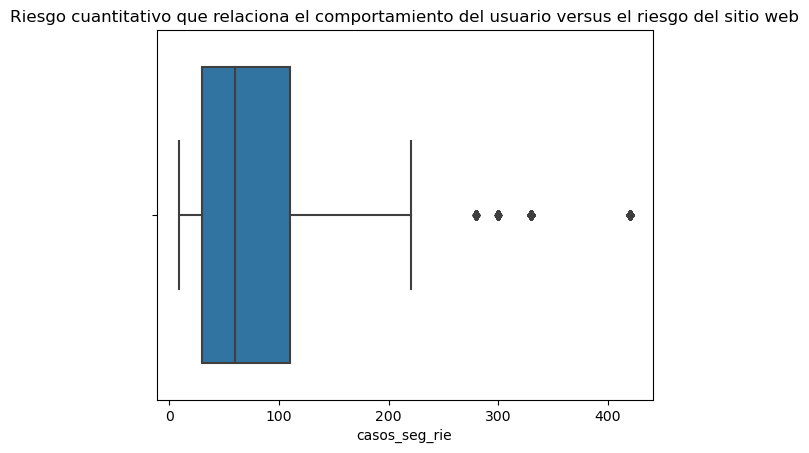

In [67]:
plt.title("Riesgo cuantitativo que relaciona el comportamiento del usuario versus el riesgo del sitio web")
sns.boxplot(x=res_crudo)

Para el objeto del presente estudio mi indicador de riesgo será para los casos mayores a 200 los cuales serán identificados como eventos atipicos y de alto riesgo.

<Axes: title={'center': 'Casos de eventos atipicos y de alto riesgo'}, ylabel='count'>

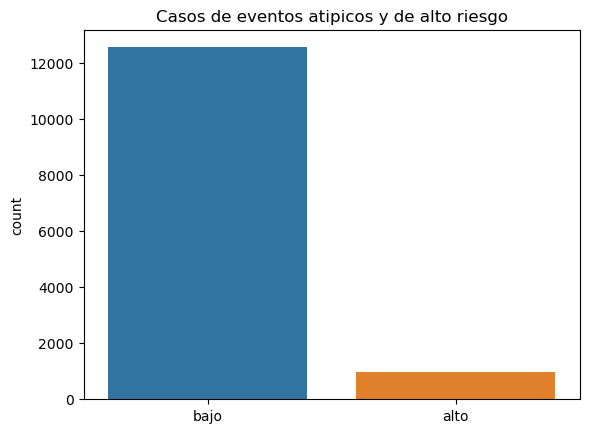

In [68]:
plt.title("Casos de eventos atipicos y de alto riesgo")
sns.countplot(x=res_procesado)

In [69]:
df_completo.columns

Index(['Date', 'Login ID', 'Action', 'Page', 'Next Page', 'Content', 'Goal',
       'experimento', 'Observation', 'Time Interval', 'Goal_processed',
       'periodo_dia', 'dia', 'riesgo', 'tiempo_creado', 'casos',
       'tipo_usuario', 'riesgo_cuantitativo'],
      dtype='object')

<font  color="green"> <b> Para los próximos resultados exploraré la aplicación de aprendizaje no supervisado y proponer modelos partiendo de las hipotesis mencionadas [previamente](#Modelamiento). </b></font> 

#### Tercer modelo 

<Axes: title={'center': 'Distribución de los casos'}, xlabel='casos', ylabel='Count'>

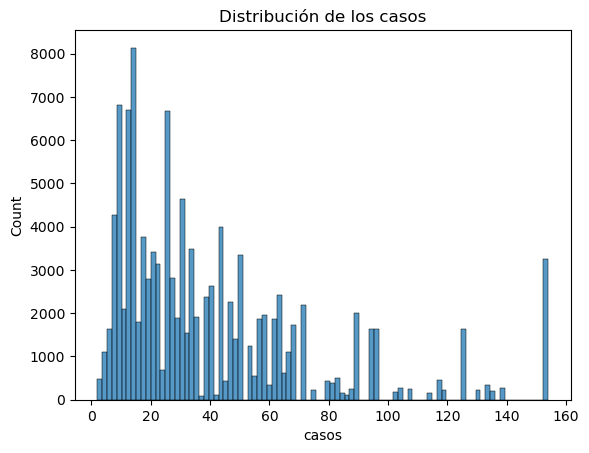

In [70]:
plt.title("Distribución de los casos")
sns.histplot(df_completo.casos)

<Axes: title={'center': 'Distribución de los casos por objetivo de usuario'}, xlabel='casos', ylabel='Count'>

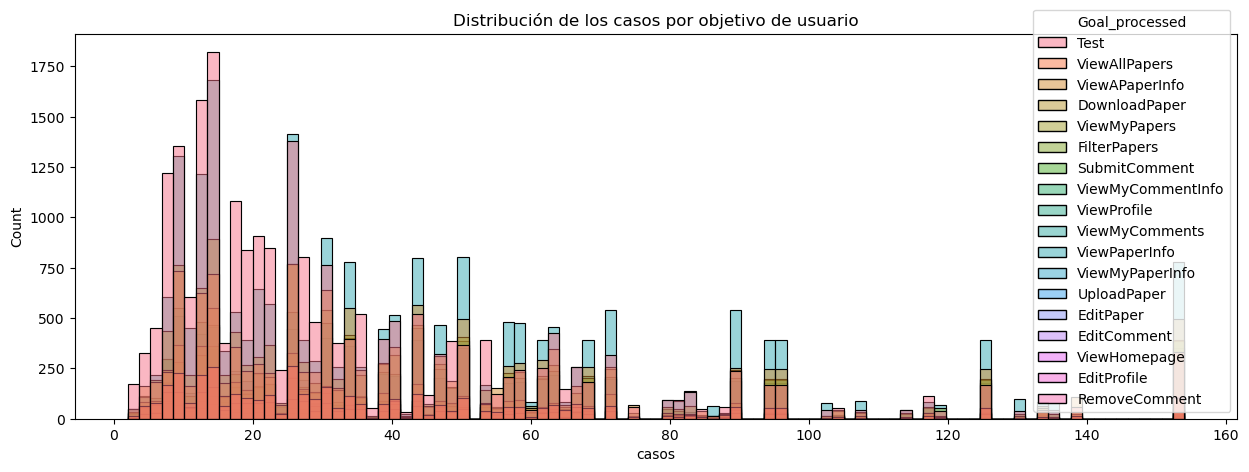

In [71]:
plt.figure(figsize=(15, 5))
plt.title("Distribución de los casos por objetivo de usuario")
sns.histplot(x="casos", data=df_completo, hue="Goal_processed")

In [72]:
df_completo.casos.describe()

count    117057.000000
mean         40.421342
std          34.008950
min           2.000000
25%          15.000000
50%          30.000000
75%          55.000000
max         154.000000
Name: casos, dtype: float64

El número de solicitudes diarios tiene un promedio de 40, sin embargo, como podemos ver hay unas tendencias marcadas a nivel del tiempo (ver EDA) y de acuerdo a los anteriores gráficos hay valores atipicos (capturados en los modelos uno y dos) que podrían ser explorados con mejor refinamiento en una aproximación de clusteres, no se explora el desarrollo de funciones de densidad ya que se parte que los datos incluyen anomalías desconocidas no filtradas. 

<Axes: xlabel='tiempo_creado', ylabel='casos'>

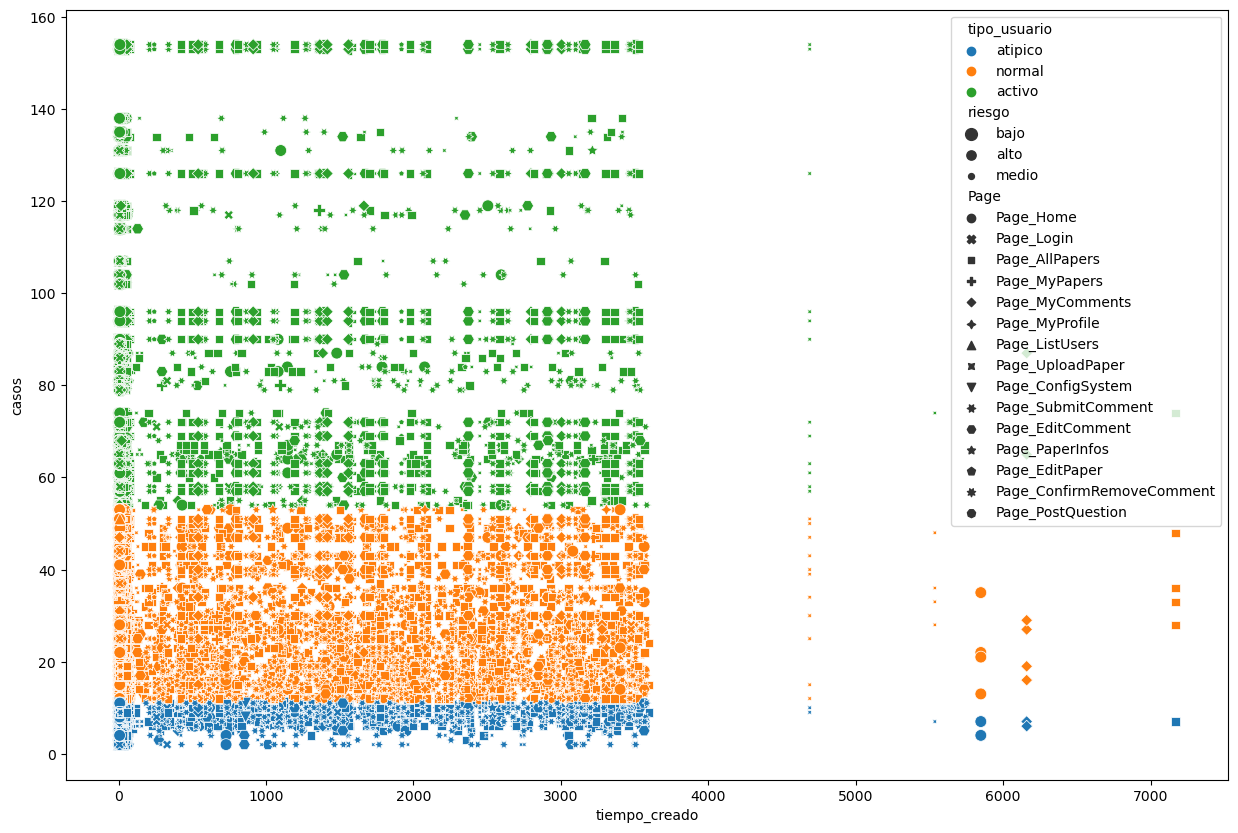

In [73]:
plt.figure(figsize=(15, 10))
plt.title("Relación entre variables cuantitativas y categoricas")
sns.scatterplot(data=df_completo[(df_completo.tiempo_creado.isna()== False) & (df_completo.casos.isna()== False)], x="tiempo_creado", y="casos", hue="tipo_usuario", style="Page", legend=True, size="riesgo")

Con el anterior gráfico contamos con cinco varibles de estudio, del anterior podemos percibir que gran parte de los casos que toman más tiempo entre acciones no son de usuarios activos y presentan riesgo alto.

In [74]:
X = df_completo.loc[(df_completo.tiempo_creado.isna()== False) & (df_completo.casos.isna()== False),["casos", "tiempo_creado"]].copy()
scaler = PowerTransformer(method='box-cox', standardize=False)
X_transformed = scaler.fit_transform(X)


In [75]:
train, test = train_test_split(X_transformed, test_size=0.4, random_state=1)

In [76]:
%%time
clf = OneClassSVM(gamma='auto')
clf.fit(train)


CPU times: total: 3min 47s
Wall time: 4min 25s


OneClassSVM(gamma='auto')

In [77]:
y_pred_train = clf.predict(train)
y_pred_test = clf.predict(test)

In [78]:
joblib.dump(clf, 'model_svm.pkl')

(67517, 2)

In [107]:
dump(clf, 'svm.joblib') 

['svm.joblib']

In [88]:
test_copia = pd.DataFrame(scaler.inverse_transform(test))
test_copia.columns = ["casos", "tiempo_creado"]
test_copia["resultados"] = y_pred_test

C:\Users\Usuario\Anaconda3\envs\melisec\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


<Axes: title={'center': 'Grafico de resultados'}, xlabel='tiempo_creado', ylabel='casos'>

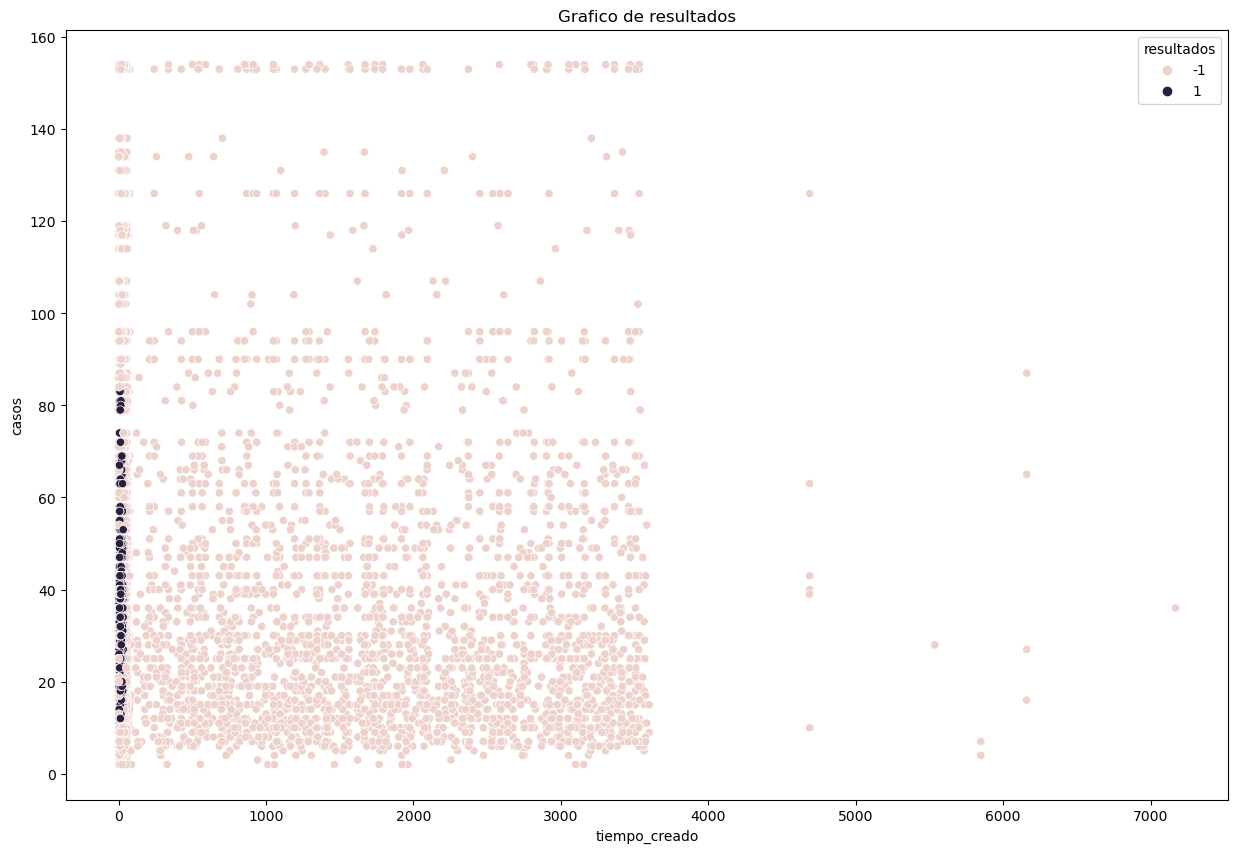

In [89]:
plt.figure(figsize=(15, 10))
plt.title("Grafico de resultados")
sns.scatterplot(data=test_copia, x="tiempo_creado", y="casos", hue="resultados")

<Axes: title={'center': 'Distribución de los casos utilizando el modelo creado'}, xlabel='casos', ylabel='Count'>

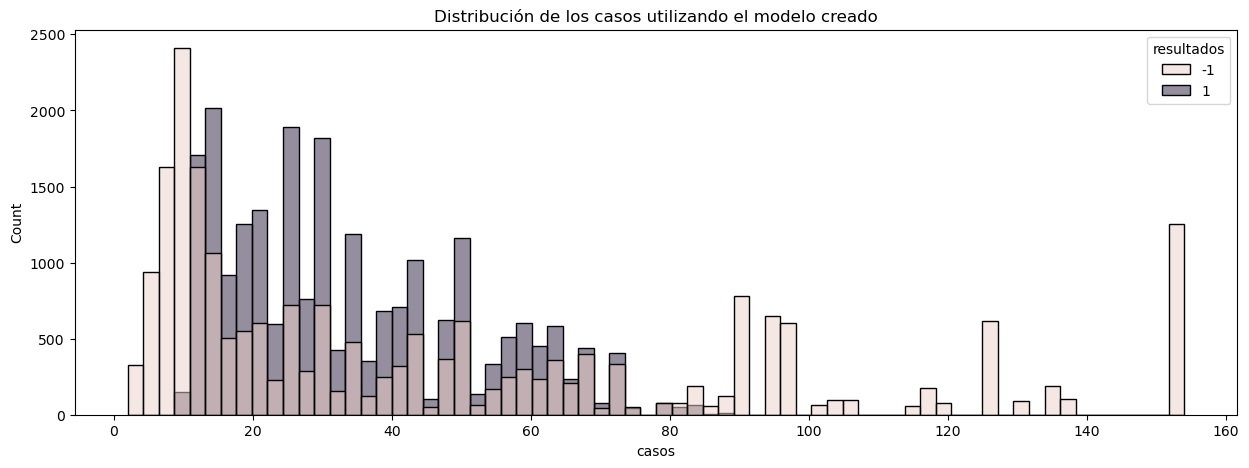

In [94]:
plt.figure(figsize=(15, 5))
plt.title("Distribución de los casos utilizando el modelo creado")
sns.histplot(x="casos", data=test_copia, hue="resultados")

<Axes: title={'center': 'Distribución de los casos utilizando el modelo creado'}, xlabel='resultados', ylabel='casos'>

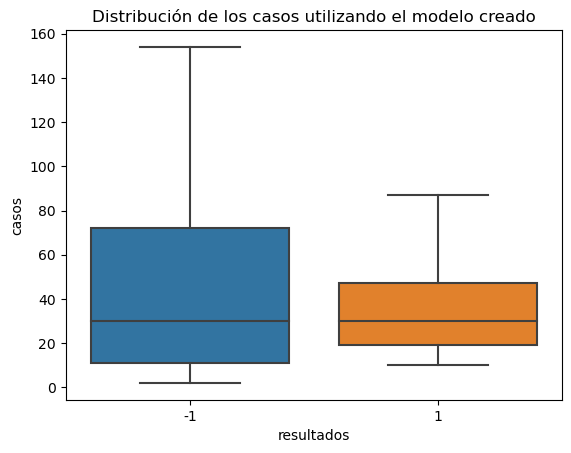

In [97]:
plt.title("Distribución de los casos utilizando el modelo creado")
sns.boxplot(data=test_copia, x="resultados", y="casos")

El anterior modelo logra perfilar en gran medida la tendencia de los datos donde los usuarios suelen realizar acciones entre 10 a 40 diarias (cluster 1), se podría decir que lo tipico.

#### Cuarto modelo

In [99]:
X = df_completo.loc[(df_completo.tiempo_creado.isna()== False) & (df_completo.casos.isna()== False),["casos", "tiempo_creado"]].copy()
scaler = PowerTransformer(method='box-cox', standardize=False)
X_transformed = scaler.fit_transform(X)


In [100]:
train, test = train_test_split(X_transformed, test_size=0.4, random_state=1)

In [106]:
kmeans = KMeans(n_clusters=2, random_state=1, n_init="auto").fit(train)

dump(kmeans, 'kmeans.joblib') 

['kmeans.joblib']

In [108]:
y_pred_test = kmeans.predict(test)

In [109]:
test_copia = pd.DataFrame(scaler.inverse_transform(test))
test_copia.columns = ["casos", "tiempo_creado"]
test_copia["resultados"] = y_pred_test

C:\Users\Usuario\Anaconda3\envs\melisec\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


<Axes: title={'center': 'Distribución de los casos utilizando el modelo creado con KMeans'}, xlabel='casos', ylabel='Count'>

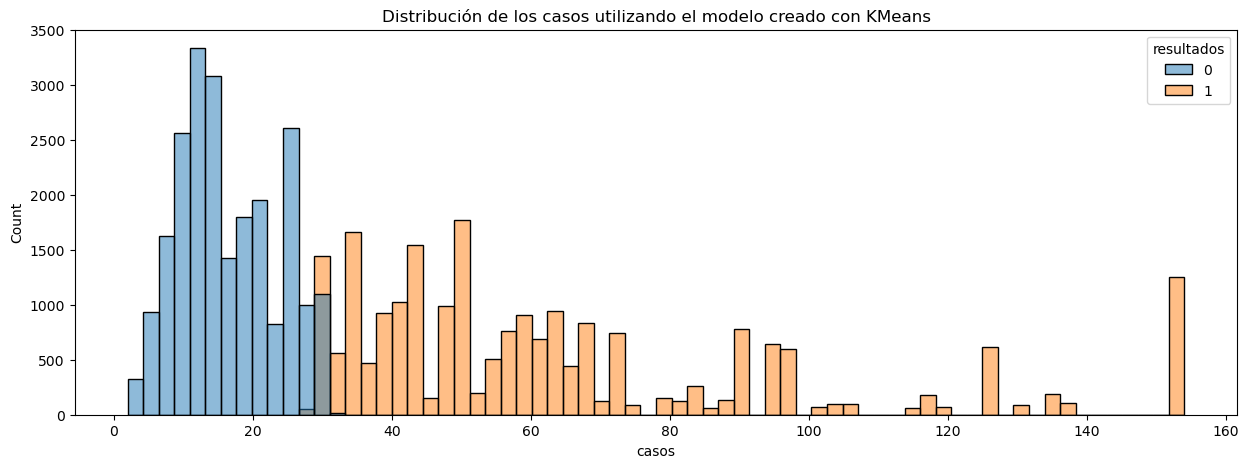

In [110]:
plt.figure(figsize=(15, 5))
plt.title("Distribución de los casos utilizando el modelo creado con KMeans")
sns.histplot(x="casos", data=test_copia, hue="resultados")

<Axes: title={'center': 'Distribución de los casos utilizando el modelo creado KMeans'}, xlabel='resultados', ylabel='casos'>

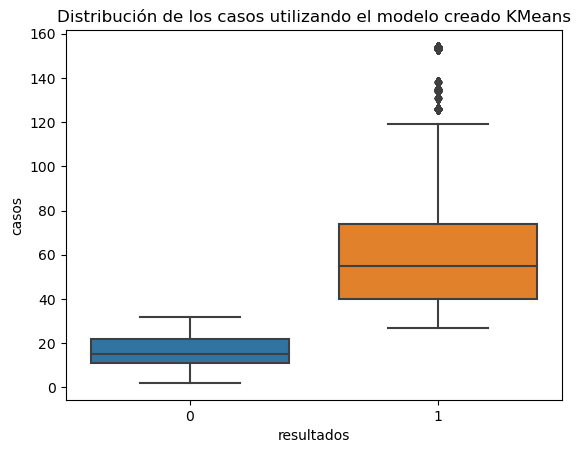

In [111]:
plt.title("Distribución de los casos utilizando el modelo creado KMeans")
sns.boxplot(data=test_copia, x="resultados", y="casos")

<Axes: title={'center': 'Grafico de resultados'}, xlabel='tiempo_creado', ylabel='casos'>

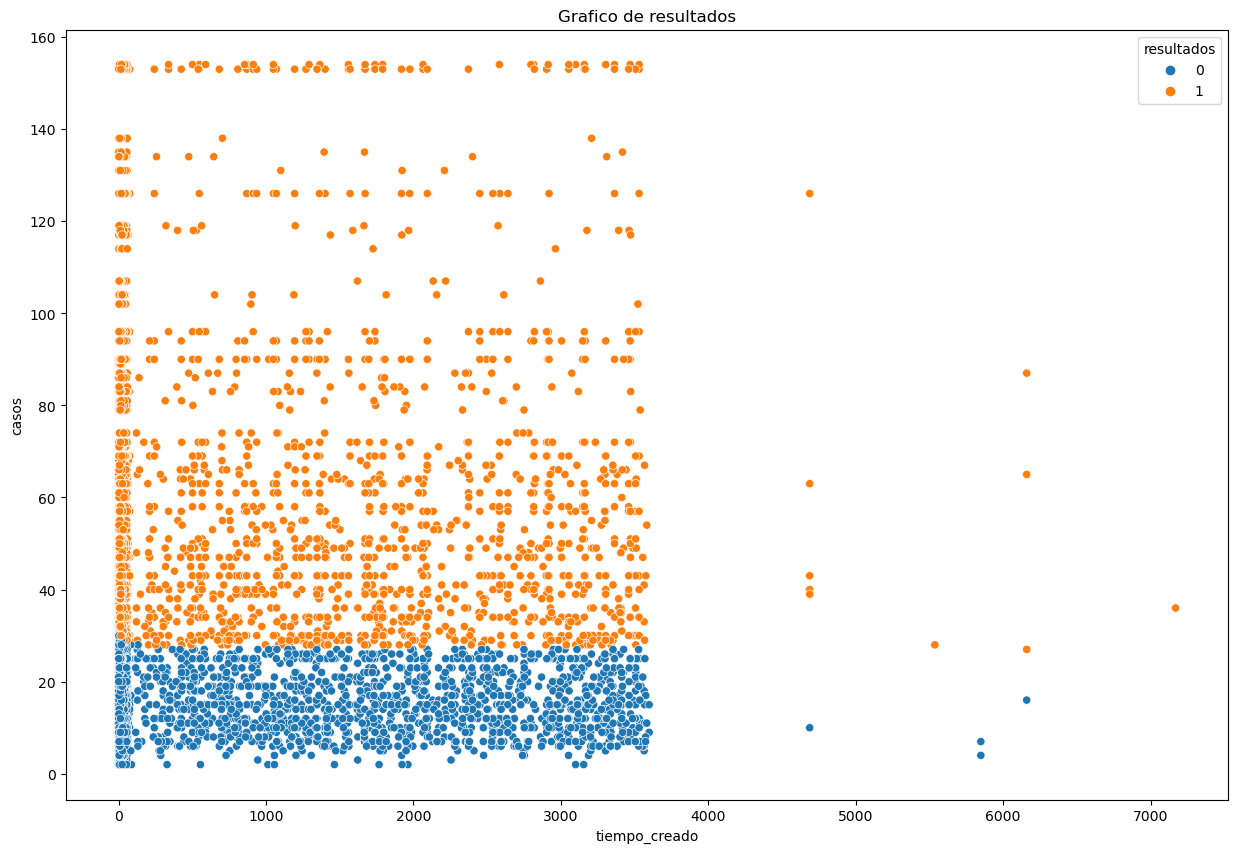

In [112]:
plt.figure(figsize=(15, 10))
plt.title("Grafico de resultados")
sns.scatterplot(data=test_copia, x="tiempo_creado", y="casos", hue="resultados")

<Axes: title={'center': 'Relación entre variables cuantitativas y categoricas'}, xlabel='tiempo_creado', ylabel='casos'>

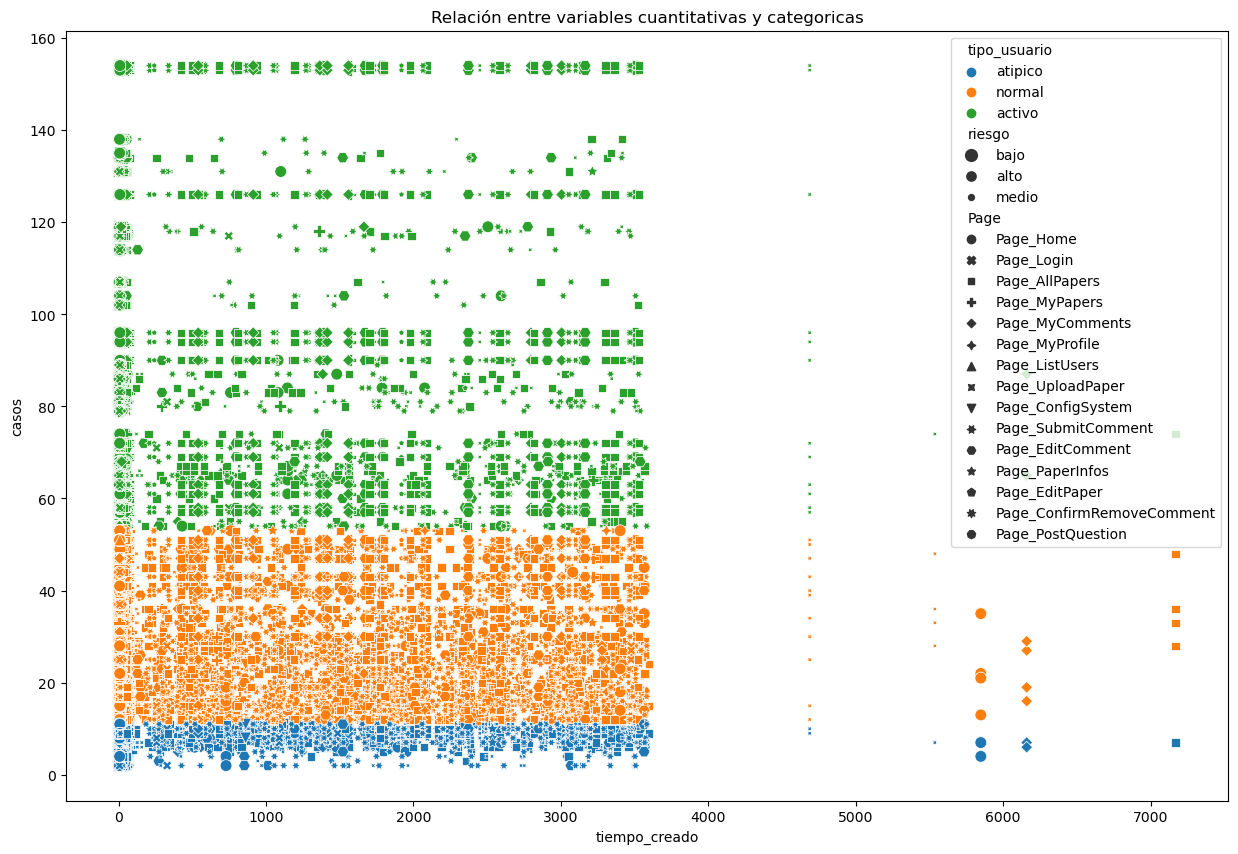

In [113]:
plt.figure(figsize=(15, 10))
plt.title("Relación entre variables cuantitativas y categoricas")
sns.scatterplot(data=df_completo[(df_completo.tiempo_creado.isna()== False) & (df_completo.casos.isna()== False)], x="tiempo_creado", y="casos", hue="tipo_usuario", style="Page", legend=True, size="riesgo")

El modelo basado KMeans tiene mejor acercamiento a la identificación de los usuarios identificados como atipicos. 

**Bonus desarrollado**✔️

***

## Conclusiones e insights

**A nivel del entendimiento al contexto de los datos**
+ El diccionario de variables no incluye los valores, formato y tipo que permitan identificar los errores en cada columna. Además, presenta un error en la enumeración de las columnas.
+ El diccionario de datos no menciona que hay una diferencia entre los dos archivos, el segundo corresponde a una captura de datos con una evolución del coRE system y un grupo distinto de usuarios.
+ Para obtener mayor interpretación de los datos hay que remitirse al paper
+ La cantidad de registros en bruto para el experimento dos es distinto a los procesados del experimento dos. Lo anterior, podría ser un problema para ser una union entre ambos conjuntos ya que no existe un identificador por registro que permita conocer el similar por registro. El anterior detalle no se presenta en el experimento uno.

**A nivel de datos**
+ Los datos incluyen problemas de registros sin valor (por ejemplo, la variable Content es la más impactada) para datos en bruto. Los datos procesados tienen valores faltantes en todas sus columnas, con un mayor impacto en Time Interval.
+ Para los conjuntos de datos brutos, los nombres de las columnas son distintos y requieren ser tratados a un mismo nivel.

**A nivel de la exploración**
+ Existe un problema de cifrado para la transferencia de los datos de login (Page_Login).
+ Tal vez el sitio web sea propenso a vulnerabilidades de XSS ya que hay comentarios que muestran código HTML y Javascript adjunto (Page_SubmitComment).
+ El top cinco de sitios web donde los usuarios interactuaron más fueron: Page_AllPapers, Page_Home, Page_Login, Page_SubmitComment.
+ Las acciones de tipo Test no se demoran más de 5 segundos, a diferencia de otras acciones que toman más tiempo relacionas a subir archivos o comentarios.
+ Los sitios como Page_SubmitComment y Page_AllPapers no han presentado gran mayoria de casos de test.
+ Las peticiones presentaron de septiembre hasta diciembre una reducción de peticiones, sin embargo durante diciembre se presento el mayor pico de casos (especialmente una alta descarga de papers). Por otra parte, a principios de septiembre hubo un pico de casos de testeo.
+ Al parecer los usuarios menos activos tienen como objetivo realizar más testeos.

**A nivel de modelamiento**
+ Del proceso hasta el momento se logran proponer cuatro modelos con distintas aproximaciones, de los anteriores el modelo basado en KMeans logra tener una identificación de usuarios atipicos de acuerdo al EDA realizado.


## Trabajo futuro

+ Se propone realizar un trabajo manual que permita identificar las anomalías con el fin de evaluar el performance de los modelos propuestos.
+ Explorar los datos de la variable Content con natural language processing (NLP) con el fin de modelar el conjunto de archivos usuales que se envian al sistema.
+ Se propone la aplicación de NLP para la identifación de elementos de valor en el texto de la variable Content.
+ Con mayor cantidad de datos en tiempo se podría realizar mejores análisis de comportamiento temporal
+ Se podría realizar un modelo de forecasting para predecir los datos cuantativos faltantes.
+ Un análisis de grafos podría ayudar a ver las agrupaciones entre usuarios y sus interacciones con las páginas del sistema
+ Aplicando un sistema de asociaciones se podría conseguir ver la relación entre acciones recurrentes y ver las posibles actividades futuras de un usuario.